# Multilingual topic modeling with BERTopic

| Authors | Last update |
|:------ |:----------- |
| Hauke Licht (https://github.com/haukelicht) | 2023-12-08 |

**_Source:_** This notebook is based on the ["Topic Modeling with BERTopic" notebook](https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-) by [Maarten Grootendorst](https://twitter.com/grtndrst). 


<a target="_blank" href="https://colab.research.google.com/github/fabiennelind/Going-Cross-Lingual_Course/blob/main/code/bertopic_multilingual.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
**Outline**

1. Setup: load libraries and set globals
2. Data: load the data
3. Topic modeling: prepare the compoments for your BERTopic model, fit it to the data, and post-process topics' bag-of-words representations
4. Evaluation: evaluate topic quality
5. Interpretation and topic labeling
6. Advanced stuff

# Setup

In [4]:
# check if on colab
try:
    import google.colab
    COLAB = True
except:
    COLAB=False
print('on colab:', COLAB)

on colab: False


In [5]:
if COLAB:
    !pip install sentence_transformers bertopic easynmt
    

In [6]:
import os
import torch
if torch.backends.mps.is_available():
    os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# for data wrangling
import pandas as pd
import numpy as np

# test processing
from nltk.corpus import stopwords
if COLAB: nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer

# for topic modeling
from sentence_transformers import SentenceTransformer # <== "document" embedding
from umap import UMAP # <== dimensionality reduction
from hdbscan import HDBSCAN # <== clustering
from bertopic.vectorizers import ClassTfidfTransformer # <== for bag-of-words topic representations

from bertopic import BERTopic # <== topic modeling

# for visaualization
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# data paths
base_bath = '..'
data = os.path.join(base_bath, 'data')

SEED = 1234

# Data

In [8]:
if COLAB:
    fp = 'https://raw.githubusercontent.com/fabiennelind/Going-Cross-Lingual_Course/main/data/lehmann%2Bzobel_2018_pimpo_positions.tsv'
else:
    fp = os.path.join('..', 'data', 'lehmann+zobel_2018_pimpo_positions.tsv')
df = pd.read_csv(fp, sep='\t')

In [9]:
df = pd.read_csv(fp, sep='\t')
print(len(df), 'sentences')

8945 sentences


Let's see how long theses sentences tend to be:

In [10]:
(df.text.str.strip().str.split('\s+', regex=True).apply(len)+1).describe().astype(int)

count    8945
mean       17
std        10
min         2
25%        10
50%        15
75%        22
max       110
Name: text, dtype: int64

Let's see how sentences are distributed across languages:

In [11]:
df.lang.value_counts()

lang
deu    3336
nld    1383
nor    1329
spa     965
dan     603
eng     552
swe     407
fin     270
fra     100
Name: count, dtype: int64

The column 'lang' indicates sentences' languages with [(bibliographic) ISO 639-2 codes](https://www.loc.gov/standards/iso639-2/php/code_list.php).
Because we'll later need to know these languages names, we'll create a [mapping](https://chat.openai.com/share/f2b9ab02-a8d4-4203-b224-42ef2fc87827) of language ISO 639-2 codes to language names.

In [13]:
langs = df.lang.unique()
lang_code2name = {
    'swe': 'swedish',
    'nor': 'norwegian',
    'dan': 'danish',
    'fin': 'finnish',
    'nld': 'dutch',
    'spa': 'spanish',
    'deu': 'german',
    'eng': 'english',
    'fra': 'french'
}

# Topic modeling

With a data frame of sentences, we could just fit a BERTopic model directly:

```python
topics, _ = BERTopic(language='multilingual').fit_transform(df.text)
```

But for many of BERTopic's components, there are good reasons to alter and costumized them.
So below, we'll create these components one by one, and then combine them in our specialized BERTopic.

## Prepare the topic model components

### 1. Sentence embeddings

The first compoment of BERTopic is an embedding model that allows generating an embedding vector for each input document.
In our case, our "documents" are (quasi-)sentences.
So we'll rely on a pre-trained sentence embedding model.
This is also BERTopic's default behavior.

However, by default, each time we fit the topic model to our texts, BERTopic will compute these embeddings.
To avoid this, we will just obtain the embeddings of the texts in our corpus once and reuse them wenever we fit a BERTopic model.
We can do this because the pre-trained sentence embedding model is deterministic.

In this way, we can  reuse our sentences' embeddings later if we change the model's parameters (e.g., during hyperparameter optimization).

source: https://colab.research.google.com/drive/1BoQ_vakEVtojsd2x_U6-_x52OOuqruj2?usp=sharing#scrollTo=sVfnYtUaxyLT

In [428]:
%%capture
# instantiate a mutlilingual sentence embedding model (source: https://www.sbert.net/docs/pretrained_models.html)
embedding_model_name = 'paraphrase-multilingual-mpnet-base-v2'
embedding_model = SentenceTransformer(embedding_model_name)

**_Note:_** The author of BERTtopic points to the leaderboard for a sentence embedding benchmark on his website: https://huggingface.co/spaces/mteb/leaderboard ([*source*](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#sentence-transformers)).
You could choose a model that achieves better performance than 'paraphrase-multilingual-mpnet-base-v2'.
(Bot not that to use embedding models from Cohere or OpenAI, you'll need API tokens; see [here](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#cohere) and [here](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#openai).)

#### Important 

It's important to remember that *every* transformer has a maximum number of tokens it can ingest per input document.
As the developer of BERTopic notes:

> ... as the name implies, the [sentence] embedding model works best for either sentences or paragraphs. This means that whenever you have a set of documents, where each documents contains several paragraphs, the document is truncated and the topic model is only trained on a small part of the data. ([*source*](https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#document-length))

So you should **always check** if the documents you want to embed are too long for the model you want to use.

In [495]:
# get the embedding model's max sequence length (measured in tokens)
embedding_model.max_seq_length

128

In [496]:
# tokenize your texts with the pre-trained model and get the length of each tokenized text
df['n_toks'] = embedding_model.tokenizer(df.text.tolist(), return_length=True, truncation=False).length

In [497]:
# compute share of sentences that will be truncated
(df['n_toks'] > embedding_model.max_seq_length).mean()

0.0003353828954723309

Fortunately, only a tiny hand full of sentences exceed the `max_seq_length` limit.
(These sentences will be truncated, meaning some words at their end will be omitted.)
So we can proceed.

**_Note:_** 
If our documents are too long, read [this thread](https://www.reddit.com/r/LanguageTechnology/comments/xh71yt/comment/j4fbqti/).
They suggest to use a Transformer model with a higher max. sequence length (e.g., a "Longformer").
This you could use to create document embeddings with the huggingface `pipeline` API (see [here](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#hugging-face-transformers)). 
Alternatively, you can consider an [alternative document representation](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html) approach.

In [432]:
# WARNING: this will take some time (~1.5 minutes) if you use a CPU
embeddings = embedding_model.encode(df.text.tolist(), show_progress_bar=True)

Batches:   0%|          | 0/280 [00:00<?, ?it/s]

### 2. Dimensionality reduction

Given embedding representations of the documents in your corpus, the next step in BERTopic is to reduce their dimensionality.
This is done to distill the relevant signlas in your corpus (i.e., reduce noise) and speed up the clustering process.

By default, BERTopic uses [UMAP](https://umap-learn.readthedocs.io) for dimensionality reduction (McInnes  et al., [2018](https://arxiv.org/abs/1802.03426)).
We will stick to this choice and use the default parameters (see [here](https://github.com/MaartenGr/BERTopic/blob/7d07e1e94e69be278f79a48d73602cdc4df0885f/bertopic/_bertopic.py#L239)) with one exception: I have increased the number of components from 5 (default) to 25.
This means that our documents will be represented in a 25-dimensional space.
Retaining more UMAP-components will provide more information to the clustering algorithm.
But you could fine-tune this parameter (see more below).

But even if you do not want to adapt the pre-set values, it's advisable to instantiate the dimensionality reduction component explicitly because this allos you to set a random seed (using the `random_state` parameter, see [here](https://colab.research.google.com/drive/1BoQ_vakEVtojsd2x_U6-_x52OOuqruj2?usp=sharing#scrollTo=28_EVoOfyZLb)):

**_Note:_** Common alternatives to UMAP for dimensionality reduction are TSNE or TruncatedSVD (see [here](https://maartengr.github.io/BERTopic/getting_started/dimensionality_reduction/dimensionality_reduction.html)).




In [779]:
umap_model = UMAP(
    n_neighbors=15, 
    n_components=25, # <== I increased this from 5 to 25
    min_dist=0.0, 
    metric='cosine', 
    random_state=SEED
)

**_Note:_** For document clustering, BERTopic uses HDBSCAN.
There is no argument for setting a seed.
So the only thing we can do to ensure reproducibility is calling `np.random.seed(SEED)` before running `BERTopic.fit_transform` (see [here](https://github.com/scikit-learn-contrib/hdbscan/issues/326#issuecomment-669323791) and [here](https://www.reddit.com/r/datascience/comments/hkm2hc/comment/fx0dam7/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button)).

### 3. Clustering method 

BERTopic finds topics by clustering the documents representation in the dimensionality-reduced embedding space.
By default, it uses the [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) clustering algorithm.

Explicitly instantiating the clustering model is important because its the only way how you can affect how many topics BERTopic discovers for your data (see [here](https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#influence-the-number-of-topics)).

Specifically, HDBSCAN has a parameter `min_topic_size` that *in*directly controls the number of topics that will be created.
A higher `min_topic_size` will generate fewer topics and a lower `min_topic_size` will generate more topics.

**_Note:_** 
There is a parameter for `BERTopic` to control the number of topics: `nr_topics`. But this parameter merges topics **after** they have been created.
So if you want to influence the number of topics at training time, this can be done through the cluster model.
by default, `BERTopic` uses HDBSCAN for clustering. 


In [780]:
cluster_model = HDBSCAN(
    min_cluster_size=30, # <== I've increased it to incentivize fewer clusters/topics
    metric='euclidean', # <== default
    cluster_selection_method='eom', # <== default
    prediction_data=True # <== required (default)
)

**_Note:_** It's also important to know that lower `min_cluster_size` will mean that the clustering algorithm runs for a longer time to converge.

#### Caveat of HDBSCAN

There is one caveat of using HDBSCAN when working with **relatively short documents**, like sentences:
It typically categorizes realtively many documents into a single outlier cluster (cf. Groot et al., [2022](https://arxiv.org/abs/2212.08459)).

I observed this, too, with our data:
When setting `min_cluster_size` to a value between 20 and 48, HDBSCAN found many topics (100+ for lower `min_cluster_size` values, around 50-30 for higher values) but assigned 50%+ documents to the outlier cluster.
When seetting `min_cluster_size` to a value between 49 and 55, HDBSCAN found typically only four topics and while only ~5% of the documents were assigned to the outlier cluster, of course the others were distributed across only very few, kind of "catch all" topics.

According to de Groot et al. ([2022](https://arxiv.org/abs/2212.08459)), one solution to this problem is to use **_k_-means** instead of HDBSCAN for clustering.
Using *k*-means has the additional benefits that 
(a) we can set the number of topics directly,
and
(b) we can set a random seed for reproducibility.
A doneside is that it has no machanism to identify outlier documents.
So we want to remember to check topics' silhouette scores during evaluation to see if there are any documents that are not well assigned to any topic!

Below we instantiate a *k*-means clustering model and set the number of topics to 25.

In [781]:
from sklearn.cluster import KMeans

cluster_model = KMeans(n_clusters=25, random_state=SEED)

### 4. Topic representation

To describe the topics BERTopic induces on your data through embedding, dimensionality reduction, and clustering, it identifies the words in a topic's documents that are most representative of that topic.
This is done by computing the *cluster*-tf-idf (c-tf-idf) score, which is just the tf-idf score computed from "topic documents", which just combine all documents assigned to a given topic into one long text (see [here](https://maartengr.github.io/BERTopic/api/ctfidf.html)).

Because the c-tf-idf alfgorithm is based on relative token counts, all the usual caveats of bag-of-words representations apply.
So it's advisable to alter this component to get rid of frequent words like "stopwords" in your topic representations (see [here](https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#removing-stop-words)).

Let's first get a list of stopwords for all the languages in our corpus:

In [782]:
# check that stopwords for all languages are available (see https://stackoverflow.com/a/60139779)
# {l: l in stopwords.fileids() for l in lang_code2name.values()}

multi_stopwords = []
for lang in lang_code2name.values(): 
    multi_stopwords += stopwords.words(lang)

len(multi_stopwords)

1601

**_Note:_** It'd be ideal to apply language-specific pre-processing and tokenization.
But this is a little advanced and we thus show you how to do it only at the end of this notebook (in the "Advanced" section).

No we can instantiate a count vectorizer that removes these stopwords and also removes very (in)frequent words.
Note that I set `max_df` relatively low since our corpus is multilingual.

In [783]:
vectorizer_model = CountVectorizer(max_df=0.80, min_df=2, ngram_range=(1, 3), stop_words=multi_stopwords)

In addition, we can explicitly configure the c-tf-idf component to reduce the impact of frequent words (by computing the square root of c-tf-idf scores, see [here](https://github.com/MaartenGr/BERTopic/blob/7d07e1e94e69be278f79a48d73602cdc4df0885f/bertopic/vectorizers/_ctfidf.py#L107C13-L107C13)).

In [784]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

## Finally: create a **Topic Modeling**

Now we are ready to instantiate our BERTopic model

**_Note:_** If you haven't pre-computed the embeddings of your documents (as we have done above), you want to add `language='multilingual'` to choose a multilingual emebdding model.


In [785]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

topic_model = BERTopic(

  # components
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=cluster_model, # <== I've replaced HDBSCAN with KMeans
  vectorizer_model=vectorizer_model,
  ctfidf_model=ctfidf_model,
  representation_model=KeyBERTInspired(top_n_words=30),
  
  # parameters
  # nr_topics=20, # WARNING: only merges topics after estimation (see https://colab.research.google.com/drive/1BoQ_vakEVtojsd2x_U6-_x52OOuqruj2?usp=sharing#scrollTo=TH6vZPGU2zpg)
  nr_topics=None, # <== I've removed this to avoid merging topics after estimation

  # Hyperparameters
  # calculate_probabilities=True, # WARNING: this can slow down BERTopic significantly at large amounts of data (>100_000 documents)
  top_n_words=30, # <== set higher than default (10) to get more keywords per topic because of multilinguality

  verbose=True
)

#### A note on the `calculate_probabilities` argument

If you set this to `calculate_probabilities=True`, BERTopic will compute the probability of each document belonging to each of the inferred topics.
This is nice because it makes BERTopic's output more akin to the output of a probabilistic topic model like LDA.

However, for large corpora, this can be computationally expensive.

What is more, whether you can obtain these quantities depends on the clustering algorithm you use.
We use *k*-means, which does not allow to compute document-topic probabilities!
(The default, HDBSCAN, does allow this. But it has the downside that it assigns many documents to an outlier cluster in our use case.)


## Training

To train/fit the model, we call the model's `fit_transform` method and provide out corpus and the pre-computed embeddings.

In [786]:
np.random.seed(SEED) # <== set seed for reproducibility
topics, probs = topic_model.fit_transform(df.text, embeddings=embeddings)

2023-12-04 18:17:24,630 - BERTopic - Reduced dimensionality
2023-12-04 18:17:25,865 - BERTopic - Clustered reduced embeddings


`topics` will record the inferred topic assignemnts (i.e., the topic label for each document in our corpus). It's a list of integers, where each integer is the index of the topic in the list of topics and the list is as long as our corpus has documents.

`probs` records the inferred topic probabilities for each document if `calculate_probabilities` is `True` (see above).
(If `calculate_probabilities` is `False`, `probs` will be `None`.)
If `calculate_probabilities` is `True`, `probs` will be a 2d numpy array of floats, with as many rows as documents documents in the corpus and as many columns as topics.


After fitting, the resulting `bertopic.BERtopic` instance (here, called "topic_model") has the following attributes:

| Attribute | Description |
|------------------------|---------------------------------------------------------------------------------------------|
| topics_               | The topics that are generated for each document after training or updating the topic model. |
| probabilities_ | The probabilities that are generated for each document if HDBSCAN is used. |
| topic_sizes_           | The size of each topic                                                                      |
| topic_mapper_          | A class for tracking topics and their mappings anytime they are merged/reduced.             |
| topic_representations_ | The top *n* terms per topic and their respective c-TF-IDF values.                             |
| c_tf_idf_              | The topic-term matrix as calculated through c-TF-IDF.                                       |
| topic_labels_          | The default labels for each topic.                                                          |
| custom_labels_         | Custom labels for each topic as generated through `.set_topic_labels`.                                                               |
| topic_embeddings_      | The embeddings for each topic if `embedding_model` was used.                                                              |
| representative_docs_   | The representative documents for each topic if HDBSCAN is used.                                                |

Let's add the model's topic assignments ("classification") to our setences data frame:


In [787]:
df['topic_'] = topic_model.topics_ 
# note: putting an underscore at the end of a (attribute) name is customary to indicate that it is an infered quantity


#### A note on terminology

BERTopic is an *unsupervised* method.
If, like me, you work a lot with labeled data, you might associate training with supervised learning.
So "training" is a bit of a misnomer.
Maybe it'd be better to say "fitting" the model.
But I just started off with the notebook the BERTopic developer provided and hence kept the terminology.

## Inspecting the output

Let's inspect a number of important attributes of the model:

In [511]:
# how many topics?
len(set(topic_model.topics_))

25

In [512]:
# how many docs assigned to outlier topic?
topic_model.get_topic_freq(-1)
# note: this will be non-zero only if you use HDBSCAN
# if you find that many docs are in the outliers topic, use k-means (see https://arxiv.org/abs/2212.08459)

0

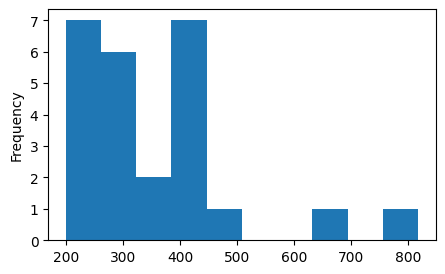

In [513]:
# how many docs per topics? (plot histogram)
topic_model.get_topic_freq()['Count'].plot(kind='hist', figsize=(5, 3))
plt.show()

In [514]:
# how large is the vocabulary?
len(topic_model.vectorizer_model.get_feature_names_out())

12460

## Post-processing

After the topic model has been fitted to the data, we can apply some post-processing steps.

One important step when applying the model to *multilingual texts* is to make the topic representations more interpretable.
Why? Well, if you look at topics top word lists, you'll realize that they are multilingual. For example, topic 0:

In [516]:
topic_model.get_topic(0)

[('uitgeprocedeerde asielzoekers', 0.7861371),
 ('asielprocedure', 0.7716244),
 ('asielzoekers', 0.77021164),
 ('asylansøgere', 0.76457906),
 ('asielverzoek', 0.76022196),
 ('asylum seekers', 0.75402075),
 ('asylsøkere', 0.74496126),
 ('asylsøknader', 0.74017274),
 ('asylverfahren', 0.7391534),
 ('demandeurs asile', 0.7328217),
 ('asielbeleid', 0.73228633),
 ('asylsuchenden', 0.73074234),
 ('asylpolitik', 0.72775984),
 ('flüchtlingspolitik', 0.7115612),
 ('asylmottak', 0.6950736),
 ('flüchtlingskonvention', 0.69245994),
 ('asylrecht', 0.6911334),
 ('opvang vluchtelingen', 0.6789593),
 ('réfugiés', 0.6370796),
 ('recht asyl', 0.6348992),
 ('flyktninger', 0.63431585),
 ('flyktningers', 0.6339409),
 ('kvoteflyktninger', 0.63348365),
 ('flygtninge', 0.6318299),
 ('asylinstituttet', 0.6318216),
 ('vluchtelingen', 0.62979364),
 ('asylwerber', 0.62482816),
 ('refugees', 0.622442),
 ('refugee', 0.61509615),
 ('flüchtlingen', 0.6132638)]

This arguable hinders interpretation.
So we want to **translate them**!

We could just iterate over the words in `topic_model.topic_representations_` and translate them.
But there is one **problem**:
To realibly translate topic words, we need to know their source languages.
But the topic model we have fitted has not retained any information about documents and hence topic words' source language.

So we create a mapping of words to their languages, which we can use to translate topic words using the appropriate source language:

In [788]:
# let's use the tokenizer used by our vectorizer model
tokenizer = topic_model.vectorizer_model.build_analyzer()
tokenizer.keywords['stop_words'] = None

# create a dictionary that maps words to languages
from collections import Counter
words2langs = {}
for i, d in df.iterrows():
    for word in tokenizer(d.text):
        if word not in words2langs:
            words2langs[word] = Counter()
        words2langs[word].update([d.lang])
# for each word, get most frequently observed langauge
words2langs = {w: words2langs[w].most_common(1)[0][0] for w, langs in words2langs.items()}

# convert to ISO 1-character language codes (required by M2M translation model)
import iso639
langs = df.lang.unique()
lang_code2code = {l: iso639.to_iso639_1(l) for l in langs}

words2langs = {w: lang_code2code[l] for w, l in words2langs.items()}

Now we'd be ready to translate topics top words by looking up for each its source language before translating it into English.

However, to make this step more reusable, I below implement a `BaseRepresentation` instance to take advantage of BERTopic's modularity (see [here](https://maartengr.github.io/BERTopic/getting_started/multiaspect/multiaspect.html)). 

**_Note:_** The point of creating a class that inherits from `bertopic.representation.BaseRepresentation` is that you could use it directly for multi-aspect topic representation and pass it, together with `bertopic.representation.KeyBERTInspired`, to `bertopic.BERTopic`'s `representation_model` argument (see [here](https://maartengr.github.io/BERTopic/getting_started/multiaspect/multiaspect.html)).

In [789]:
from typing import List, Mapping, Tuple, Optional
import torch
from easynmt import EasyNMT
from bertopic.representation import BaseRepresentation
from scipy.sparse import csr_matrix

class TopicWordsTranslations(BaseRepresentation):
    def __init__(self,
            words2langs: Mapping[str, str],
            translation_model: str = 'm2m_100_418M',
            target_language: str = 'en',
            device: Optional[str] = None
        ):
        
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu' # easyNMT does not support macOS M1/mps yet
        self.translation_model = EasyNMT(translation_model, device=device)
        if target_language not in self.translation_model.get_languages():
            raise ValueError(f'target language "{target_language}" not supported by translation model {translation_model}')
        self.target_language = target_language
        not_supported = [
            lang 
            for lang in set(words2langs.values()) 
            if lang not in self.translation_model.get_languages(target_lang=target_language) and lang != self.target_language
        ]
        if len(not_supported) > 0:
            raise ValueError(f'source language(s) "{not_supported}" not supported by translation model {translation_model}')
        self.words2langs = words2langs
        
    def extract_topics(self,
                       topic_model,
                       documents: Optional[pd.DataFrame],
                       c_tf_idf: Optional[csr_matrix],
                       topics: Mapping[str, List[Tuple[str, float]]]
                       ) -> Mapping[str, List[Tuple[str, float]]]:
        """ Extract topics

        Arguments:
            topic_model: A BERTopic model
            documents (optional): All input documents
            c_tf_idf (optional): The topic c-TF-IDF representation
            topics: The candidate topics as calculated with c-TF-IDF

        Returns:
            translated_topics: topic representations with translated topic words
        """
        from tqdm.auto import tqdm
        translated_topics = {}
        for topic_id, words in tqdm(topics.items(), total=len(topics)):
            translated_topics[topic_id] = []
            for word, score in words:
                src = self.words2langs[word] if word in self.words2langs else None
                if src == self.target_language:
                    translated_topics[topic_id].append((word, score))
                    continue
                translation = self.translation_model.translate(
                    word, 
                    perform_sentence_splitting=False,
                    target_lang=self.target_language, 
                    document_language_detection=False,
                    source_lang=src,
                    batch_size=1, 
                    show_progress_bar=False
                )
                translated_topics[topic_id].append((translation + f' ({src})' if src else '', score))

        return translated_topics

We can use or custom translation representation and add it to the representations that should be generated for our topic model ([source](https://maartengr.github.io/BERTopic/getting_started/multiaspect/multiaspect.html)):

In [790]:
from bertopic.representation import KeyBERTInspired

main_representation = KeyBERTInspired(top_n_words=30)

# Add all models together to be run in a single `fit`
representation_model = {
    'Main': main_representation,
    'Translation': TopicWordsTranslations(words2langs=words2langs) # takes some time to instantiate because the translation model is loaded
}

Now we can update the topic model to add the topic words translations:

In [802]:
topic_model.update_topics(df.text, representation_model=representation_model, top_n_words=30)

  0%|          | 0/25 [00:00<?, ?it/s]

# Evaluation

There is quite some literature on evaluating topic models (e.g., Wallach et al., [2009](https://www.cs.cmu.edu/~rsalakhu/papers/etm.pdf); Lau et al., [2014](https://aclanthology.org/E14-1056.pdf); Röder et al., [2015](https://doi.org/10.1145/2684822.2685324)) that has proposed topic-model specific evaluation metrics, formostly *coherence*.

But since BERTopic is effectively a *clustering method*, where the topic-like flavor comes only trough the added (post-clustering) identification of characteristic topic words, its helpful to consult the literature on evaluating clusterings, too (see [here](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)).

Importantly, we have no ground-truth document class assignments against which we could compare the topics BERTopic has found.
So we need to constraint ourselves to unsupervised evaluation methods like silhouette scores.

## Coherence

Coherence indicates how much a set of statements supports each other ()
In the context of topic modeling, coherence is a measure of how semantically similar the words in a topic are.
There are different coherence measures ([source](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#e51b))

- $C_\text{v}$ measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
- $C_\text{p}$ is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson’s coherence
- $C_\text{uci}$ measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words
- $C_\text{umass}$ is based on document co-occurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure
- $C_\text{npmi}$ is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)
- $C_\text{a}$ is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

ChatGPT can help you in understanding in detail how these measures are computed ([example](https://chat.openai.com/share/743c0a0f-fece-40ec-bae6-fd13eff4fb7b)

In [644]:
from typing import Union, List, Literal, Tuple, Dict
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

def compute_coherece(
        model: BERTopic, 
        docs: Union[pd.Series, List[str]], 
        coherence_metric: Literal['u_mass', 'c_v', 'c_uci', 'c_npmi']='c_v',
    ) -> Tuple[Dict[str, Union[float, Dict[int, float]]], CoherenceModel]:
    """
    Compute coherence scores for a BERTopic model.

    Parameters:
        model (BERTopic): The BERTopic model.
        docs (Union[pd.Series, List[str]]): The documents to compute coherence on.
            Must be a pandas Series or a list of strings.
        coherence_metric (Literal['u_mass', 'c_v', 'c_uci', 'c_npmi'], optional): The coherence metric to use. 
            Allowed values are 'u_mass', 'c_v', 'c_uci', 'c_npmi' (see https://radimrehurek.com/gensim/models/coherencemodel.html)
            Defaults to 'c_v'.

    Returns:
        Tuple[Dict[str, Union[float, Dict[int, float]]], CoherenceModel]: 
           A tuple containing the coherence scores and the coherence model.
            - scores (Dict[str, Union[float, Dict[int, float]]]): The coherence scores.
                - overall (float): The overall coherence score.
                - by_topic (Dict[int, float]): The coherence score for each topic.
            - coherence_model (CoherenceModel): The coherence model object.

    """
    # get topic top-n words
    topic_words = [
        [word for word, _ in words] # for top-n words words in topic
        for tid, words in model.topic_representations_.items() # iterate over topics
        if tid > -1 # exclude outlier topic
    ]

    # extract vectorizer and analyzer from BERTopic
    vectorizer = model.vectorizer_model
    analyzer = vectorizer.build_analyzer()
    
    if isinstance(docs, list):
        docs = np.array(docs)
    cleaned_docs = model._preprocess_text(docs)
    toks = [analyzer(doc) for doc in cleaned_docs]

    # get topics
    topics = model.topics_

    # pre-process documents
    documents = pd.DataFrame({"Document": toks, "ID": range(len(docs)), "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': 'sum'})

    # extract features for Topic Coherence evaluation
    # words = vectorizer.get_feature_names_out()
    tokens = documents_per_topic.Document.to_list()
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    
    # compile coherence model
    coherence_model = CoherenceModel(
        topics=topic_words, 
        texts=tokens, 
        corpus=corpus,
        dictionary=dictionary, 
        coherence=coherence_metric
    )

    # evaluate coherence
    scores = {
        'overall': coherence_model.get_coherence(),
        'by_topic': {tid: c for tid, c in enumerate(coherence_model.get_coherence_per_topic())}
    }
    
    return scores, coherence_model


In [523]:
coherence_scores, _ = compute_coherece(topic_model, df.text, coherence_metric='c_v')

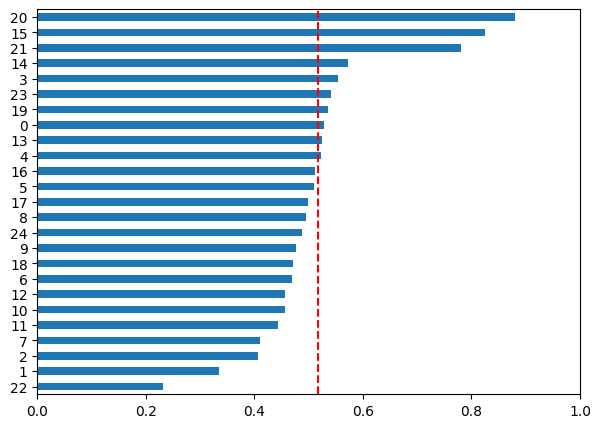

In [524]:
# visualize
def plot_topic_coherence_scores(scores, add_overall=True):
    coherences_df = pd.DataFrame(
        scores['by_topic'].values(), 
        index=range(len(scores['by_topic'])), 
        columns=['coherence']
    )
    # create new plot
    plt.figure(figsize=(7, 5))
    coherences_df.sort_values(by='coherence', inplace=True)
    coherences_df['coherence'].plot(kind='barh')
    if add_overall:
        # draw a vertical line at the overall coherence score
        plt.axvline(scores['overall'], color='red', linestyle='--')
    plt.xlim(0, 1)
    plt.show()

plot_topic_coherence_scores(coherence_scores)

#### Caveat

I'm a little concerned that the coherence scores are affected by topics' degree of mutlilinguality.
The coherence score is based on topic words' word co-occurences.
Words from different languages won't co-occur.
So if a topic is very multilingual (i.e., groups documents from different language subset of our corpus), then the co-occurence of words in that topic will be lower than for a topic that is monolingual.

Now, the issue is that to compute coherence, we need the entire corpus, not only the topic words.
So we can't just input our topic word translations. 🤷‍♂️

## Silhouette scores

Silhouette scores are a measure of how well documents are assigned to their topics.
They are computed for each document and range from -1 to 1.
Specificallly, they are computed as follows:

- for each sample, compute
    - $a$, the mean distance between a sample and all other points in the same class, and 
    - $b$, the mean distance between a sample and all other points in the next nearest cluster.
    - the *silhouette coefficient* as $s = (b - a) / max(a, b)$ 
- compute the *silhouette score* for a clustering solution of a set of documents as the mean of the silhouette coefficients for all samples.

**Interpretation**

At the sample level:

- The higher the coeficient, the better the document is assigned to its topic.
- The lower the coeficient, the more likely it is that the document is not well assigned to its topic.

At the corpus level: the higher the scorem the better the clustering solution.

In [525]:
from sklearn.metrics import (
    silhouette_score, # <== compute overall, corpus-level score
    silhouette_samples # <== compute sample/document-level scores
)

In [531]:
# corpus level
overall_silhouette_score = silhouette_score(
    X=topic_model.umap_model.embedding_, 
    labels=topic_model.topics_, 
    sample_size=None, # <== None means do not subsample observations
    random_state=SEED # <== only used to make subsampling reproducible (if applied)
)
overall_silhouette_score

0.40716907

In [527]:
silhouette_scores = silhouette_samples(X=topic_model.umap_model.embedding_, labels=topic_model.topics_)

In [591]:
# mean and standard deviation of silhouette scores by topic
silhouette_scores_by_topic = pd.DataFrame({'topic': topic_model.topics_, 'silhouette_score': silhouette_scores})
silhouette_scores_by_topic = silhouette_scores_by_topic.groupby('topic').agg(['mean', 'std'])
# remove stacked columns
silhouette_scores_by_topic.columns = silhouette_scores_by_topic.columns.droplevel(0)
silhouette_scores_by_topic.reset_index(inplace=True)
silhouette_scores_by_topic.sort_values(by='mean')

,topic,mean,std
19,19,0.235276,0.124696
5,5,0.252555,0.160637
7,7,0.254906,0.129412
12,12,0.262122,0.148985
18,18,0.277445,0.168626
24,24,0.286935,0.188434
0,0,0.302841,0.145356
11,11,0.309283,0.167678
14,14,0.311324,0.146180
6,6,0.312266,0.162143


<Axes: >

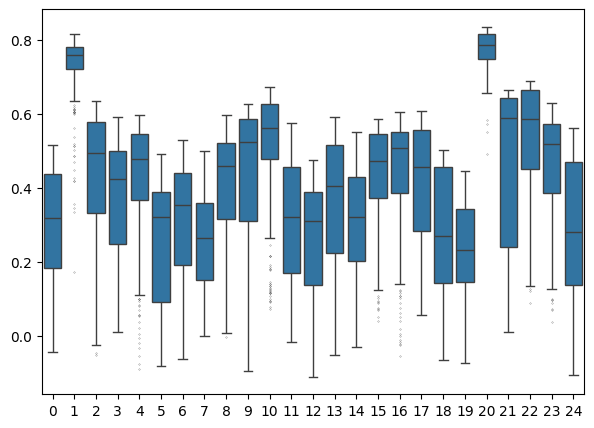

In [530]:
# plot a boxplot (along x-axis) by topic (y-axis)
plt.figure(figsize=(7, 5))
sns.boxplot(x=topic_model.topics_, y=silhouette_scores, fliersize=.2)


Topics 1 and 2 have lovely silhouttes, meaning that they are comparatively well-formed.
Topic 19 less so.

Now, there's always gonna be some heterogeneity in the quality *between* the topics identified by a topic model.
(If you ever fit a topic model where all topics have very high and concentrated silhouette scores, please send me an email with a screenshot.)

But the **aggregate information** is still useful to decide between different topic models fitted to the same data.


In [532]:
overall_silhouette_score, \
silhouette_scores_by_topic[('silhouette_score', 'mean')].mean(), \
silhouette_scores_by_topic[('silhouette_score', 'mean')].std()

(0.40716907, 0.4045012, 0.13894601)

In [572]:
silhouette_scores_by_topic

silhouette_score          
                  mean       std
topic                           
20            0.775411  0.051748
1             0.740697  0.065513
22            0.543362  0.138433
10            0.521104  0.143345
21            0.479360  0.203162
23            0.461773  0.151001
9             0.453333  0.163714
16            0.448697  0.152330
2             0.447213  0.154692
15            0.438770  0.125871
4             0.428920  0.151990
17            0.414326  0.155854
8             0.408076  0.147880
3             0.378542  0.161598
13            0.367993  0.159764
6             0.312266  0.162143
14            0.311324  0.146180
11            0.309283  0.167678
0             0.302841  0.145356
24            0.286935  0.188434
18            0.277445  0.168626
12            0.262122  0.148985
7             0.254906  0.129412
5             0.252555  0.160637
19            0.235276  0.124696

**_Note:_** we want to reuse the code above later. So we wrap it in a fucntion:

In [595]:
def compute_silhouette_scores(model: BERTopic):
    overall = silhouette_score(
        X=model.umap_model.embedding_, 
        labels=model.topics_, 
        sample_size=None, 
        random_state=SEED
    )
    by_topic = silhouette_samples(X=model.umap_model.embedding_, labels=model.topics_)
    by_topic = pd.DataFrame({'topic': model.topics_, 'silhouette_score': by_topic})
    by_topic = by_topic.groupby('topic').agg(['mean', 'std'])
    # remove stacked columns
    by_topic.columns = by_topic.columns.droplevel(0)
    by_topic.reset_index(inplace=True)
    out = {
        'overall': overall,
        'by_topic': by_topic
    }
    return out

In [596]:
# test
compute_silhouette_scores(topic_model)

{'overall': 0.40716907,
 'by_topic':     topic      mean       std
 0       0  0.302841  0.145356
 1       1  0.740697  0.065513
 2       2  0.447213  0.154692
 3       3  0.378542  0.161598
 4       4  0.428920  0.151990
 5       5  0.252555  0.160637
 6       6  0.312266  0.162143
 7       7  0.254906  0.129412
 8       8  0.408076  0.147880
 9       9  0.453333  0.163714
 10     10  0.521104  0.143345
 11     11  0.309283  0.167678
 12     12  0.262122  0.148985
 13     13  0.367993  0.159764
 14     14  0.311324  0.146180
 15     15  0.438770  0.125871
 16     16  0.448697  0.152330
 17     17  0.414326  0.155854
 18     18  0.277445  0.168626
 19     19  0.235276  0.124696
 20     20  0.775411  0.051748
 21     21  0.479360  0.203162
 22     22  0.543362  0.138433
 23     23  0.461773  0.151001
 24     24  0.286935  0.188434}

## Evaluation of multilingual models

**_Disclaimer:_** I've implemented the following metrics based on best-practices in the applications of LDA topic models to translated texts of multilingual corpora.

### Language diversity/concentration of topics

A first descriptive metric is the language diversity of topics.
Diversity measures how many languages are represented in a topic.

#### Relative language distribution of topics 

There are potentially a number of ways to operationalize diversity/concentration.
A very simple way is to just compute how frequently each language occurs in a topic.
We can compute these quantities as follows:

1. take the topic model's topic assignment/classification (based on documents' maximum topic probabilities)
2. for each topic, count how often documents written in language a, b, c, etc. are assigned to it
3. normalize these counts by the number of documents in the topic

This way we can spot topics that are dominated by documents in one language.

In [597]:
topic_language_stats = {}
for topic_id, d in df.groupby(topic_model.topics_):
    # compute relative frequency of languages in topic
    lang_shares = d.lang.value_counts(normalize=True)
    # compute adjusted frequency of languages in topic
    af = d.lang.value_counts(sort=False, dropna=True).sort_index()/df.lang.value_counts(normalize=True, sort=False).sort_index()
    af /= af.sum()
    af
    # store stats
    topic_language_stats[topic_id] = {
        'language_distribution': lang_shares.to_dict(), 
        'language_distribution_adjusted': af.to_dict(), 
        'n_langs': len(lang_shares),
        'n_docs': len(d)
    }

We can just tabulate the values by language and topic

In [598]:
topic_language_distribution = pd.DataFrame(
    [v['language_distribution'] for v in topic_language_stats.values()], 
    index=topic_language_stats.keys()
)
topic_language_distribution.fillna(0).round(3)

,deu,nor,nld,eng,dan,spa,fin,swe,fra
0,0.339,0.202,0.165,0.116,0.076,0.029,0.027,0.026,0.020
1,0.006,0.534,0.000,0.001,0.249,0.000,0.092,0.116,0.001
2,0.538,0.016,0.138,0.020,0.029,0.183,0.027,0.009,0.040
3,0.359,0.130,0.116,0.123,0.049,0.144,0.023,0.039,0.019
4,0.362,0.175,0.144,0.052,0.028,0.104,0.052,0.080,0.002
5,0.360,0.060,0.071,0.181,0.081,0.181,0.031,0.024,0.012
6,0.441,0.157,0.184,0.034,0.044,0.053,0.024,0.061,0.002
7,0.417,0.085,0.199,0.068,0.083,0.075,0.032,0.017,0.024
8,0.332,0.048,0.131,0.123,0.058,0.222,0.033,0.048,0.005
9,0.401,0.146,0.189,0.035,0.073,0.093,0.003,0.060,0.000


While you might want to put such a table in the appendix or supporting materials of your analysis, it's a little overwhelming to look at.

So we can visualize the distribution of languages across topics with a [heatmap](https://en.wikipedia.org/wiki/Heat_map).

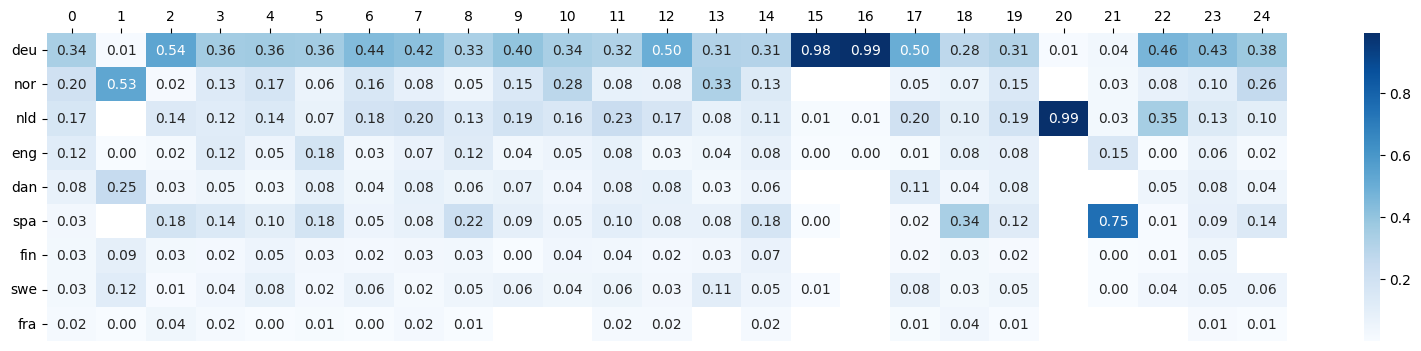

In [599]:
# create a heatmap of the language distribution for each topic
fig, ax = plt.subplots(figsize=(20, 4))
sns.heatmap(topic_language_distribution.T, ax=ax, cmap='Blues', annot=True, fmt='.2f')
# put x.axis labels on top
ax.xaxis.tick_top()
# rotate y.axis labels
plt.yticks(rotation=0)
plt.show()

Note that the heatmap is a little misleading because the language distribution in our data is imbalanced.
For example, it seems that most topics are dominated by German documents.
But this is unsuprising, since German documents are the most prevalent in the corpus.

In [600]:
df.lang.value_counts()

lang
deu    3336
nld    1383
nor    1329
spa     965
dan     603
eng     552
swe     407
fin     270
fra     100
Name: count, dtype: int64

So let's take the adjusted values instead:

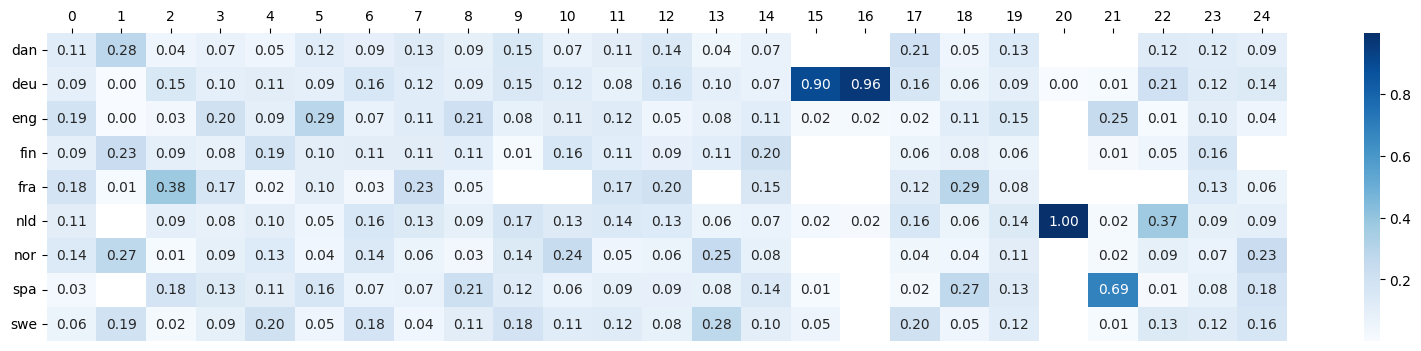

In [601]:
topic_language_distribution = pd.DataFrame(
    [v['language_distribution_adjusted'] for v in topic_language_stats.values()], 
    index=topic_language_stats.keys()
)
fig, ax = plt.subplots(figsize=(20, 4))
sns.heatmap(topic_language_distribution.T, ax=ax, cmap='Blues', annot=True, fmt='.2f')
ax.xaxis.tick_top()
plt.yticks(rotation=0)
plt.show()

Now we can see more clearly wich topics are relatively balanced compared to the language distribution in the entire corpus (e.g., 0, 3, 8, 23) and which are not (e.g., 20, 16, 15, 21).

We can also summarize this by computing the standard deviation on adjusted language distribution values:

In [602]:
language_imbalance_by_topic = topic_language_distribution.T.apply('std').sort_values(ascending=False)
language_imbalance_by_topic # <== higher Std. values => higher language imbalance

20    0.702356
16    0.545757
15    0.388936
21    0.254601
1     0.132740
22    0.119681
2     0.114569
18    0.097737
13    0.088811
5     0.076668
17    0.076142
24    0.064421
8     0.063002
4     0.057283
9     0.055828
10    0.055507
7     0.054170
0     0.052861
6     0.050952
12    0.050043
14    0.046153
3     0.045899
11    0.036064
19    0.029602
23    0.028432
dtype: float64

This shows that topic 23 is the most language-balanced and topic 20 the least language balanced.

In [541]:
language_imbalance_by_topic.mean(), language_imbalance_by_topic.std()

(0.13152857441194285, 0.16889195131268508)

#### Language entropy of topics

Another way to measure the language diversity of topics is to compute the entropy of the language distribution in each topic.
While entropy has been introduced in information theory as a measure of uncertainty, it can be used to measure the diversity of a distribution (*note:* sampling from a very spread-out distribution means to have lower certainty about what a sample's value will be).

The formular to compute entropy is:

$$
H(X) = - \sum_{i=1}^n P(x_i) \log_b P(x_i)
$$

where $P(x_i)$ is the probability of the $i$-th value in the distribution $X$ and $b$ is the base of the logarithm (typically 2 or $e$).

The entropy of a distribution is maximized when all values in the distribution are equally likely.
So the entropy of a distribution is a measure of its diversity.

We can compute the entropy of the language distribution in each topic as follows:

$$
H = - \sum_{i=1}^n \frac{f_i}{N} \log_2 \frac{f_i}{N}
$$

where $f_i$ is the frequency of the $i$-th language in the topic and $N$ is the number of documents in the topic.

Let's compute the entropy of the language distribution in each topic:


In [542]:
topic_entropies = {}
for topic_id, d in df.groupby(topic_model.topics_):
    topic_entropies[topic_id] = d.lang.value_counts(normalize=True).apply(lambda p: -p*np.log(p)).sum()

In [543]:
topic_entropies_df = pd.DataFrame(topic_entropies.values(), index=topic_entropies.keys(), columns=['entropy'])
topic_entropies_df.sort_values(by='entropy')

,entropy
20,0.046905
16,0.064165
15,0.144558
21,0.862573
1,1.200398
22,1.305539
2,1.432470
17,1.497878
12,1.608794
24,1.631975


In [545]:
topic_entropies_df.entropy.mean(), topic_entropies_df.entropy.std()

(1.4667929870106224, 0.5747717935137043)

let's compare it with our language (im)balance indicator:

Text(0, 0.5, 'language imbalance')

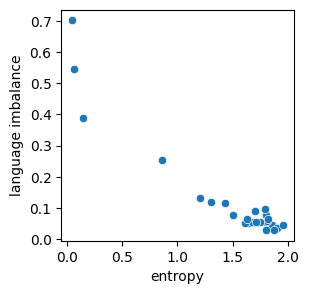

In [477]:
# plot the entropy values against the language imbalance values
fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(
    x=topic_entropies_df.entropy, 
    y=language_imbalance_by_topic.sort_index(), 
    ax=ax
)
# name the y-axis
ax.set_ylabel('language imbalance')

Of course, they are clearly (negatively) related: high imbalance means low entropy and vice versa.

We can now see if the coherence scores are related to the language diversity of topics:

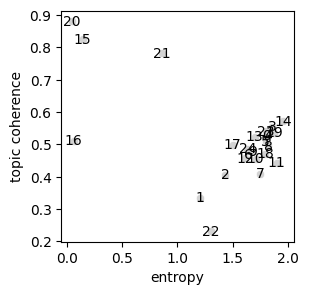

In [546]:
# plot the entropy values against the topic coherence scores
fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(
    x=topic_entropies_df.entropy, 
    y=pd.Series(coherence_scores['by_topic']).sort_index(), 
    color='lightgrey',
    ax=ax
)
# label the y-axis
ax.set_ylabel('topic coherence')
# label points with topic IDs
for topic_id, row in topic_entropies_df.iterrows():
    ax.text(row.entropy, coherence_scores['by_topic'][topic_id], topic_id, horizontalalignment='center', verticalalignment='center')

**_Note:_** We again wrap the code in a function so that we can reuse it later:

In [649]:
def compute_topic_language_stats(df, topics):
    stats = {}
    for tid, d in df.groupby(topics):
        # compute relative frequency of languages in topic
        lang_shares = d.lang.value_counts(normalize=True)
        # compute adjusted frequency of languages in topic
        af = d.lang.value_counts(sort=False, dropna=True).sort_index()/df.lang.value_counts(normalize=True, sort=False).sort_index()
        af /= af.sum()
        # entropy
        e = lang_shares.apply(lambda p: -p*np.log(p)).sum()
        # store stats
        stats[tid] = {
            'language_distribution': lang_shares.to_dict(), 
            'language_distribution_adjusted': af.to_dict(), 
            'entropy': e,
            'n_langs': len(lang_shares),
            'n_docs': len(d)
        }
    return stats

In [634]:
# test
topic_lang_stats = compute_topic_language_stats(df, topic_model.topics_)
topic_lang_distr = pd.DataFrame(
    [v['language_distribution_adjusted'] for v in topic_lang_stats.values()], 
    index=topic_lang_stats.keys()
)
imbalences = topic_lang_distr.T.apply('std')
imbalences.to_dict()

{0: 0.05286066926220045,
 1: 0.1327404981073621,
 2: 0.11456852075404025,
 3: 0.04589910393358572,
 4: 0.05728322533496777,
 5: 0.07666805014603724,
 6: 0.05095222930294827,
 7: 0.05417026288953226,
 8: 0.06300161723399327,
 9: 0.055828482772370513,
 10: 0.05550654272801998,
 11: 0.03606371740967289,
 12: 0.050042529049134914,
 13: 0.08881128201090874,
 14: 0.0461534797288408,
 15: 0.388935500324297,
 16: 0.5457569729968065,
 17: 0.07614228404371243,
 18: 0.09773731860395077,
 19: 0.029601713936004807,
 20: 0.7023562222829429,
 21: 0.254600536299574,
 22: 0.11968082160757712,
 23: 0.028431523899022326,
 24: 0.06442125564106749}

{0: 0.04983751692448164,
 1: nan,
 2: 0.10801623724759142,
 3: 0.043274090189099466,
 4: 0.054007142776790334,
 5: 0.07228333087815093,
 6: 0.04803822247558218,
 7: 0.05107221363712832,
 8: 0.05939849436250119,
 9: nan,
 10: nan,
 11: 0.034001198846900074,
 12: 0.04718054885115745,
 13: nan,
 14: 0.04351391798882558,
 15: nan,
 16: nan,
 17: 0.07178763384312174,
 18: 0.0921476276797916,
 19: 0.0279087635451911,
 20: nan,
 21: nan,
 22: nan,
 23: 0.02680549779795477,
 24: nan}

### Cross-lingual consistency

Because we fit BERTopic to a multilingual corpus, our topic representations of top-$n$ representative words are multilingual.

However, to assess if topics representation across languages align across languages, 
we want to get language-specific representations for each topic.

We can obtain language-specific word lists for each topic by subsetting the corpus by language, recomputing words c-tf-idf scores, and then extracting the top-$n$ words for each topic:

In [605]:
topic_language_representations = {}
min_docs = 10

# Grouping the dataframe by language
for lang, d in df.groupby('lang'):
    print(f'Computing topic representations for "{lang}"')

    # Selecting the 'text' and 'topic_' columns and renaming them
    selection = d[['text', 'topic_']].rename(columns={'text': 'Document', 'topic_': 'Topic'})

    # Counting the number of documents per topic
    docs_per_topic = selection.Topic.value_counts()

    # Filtering out topics with fewer than 'min_docs' documents
    issues = docs_per_topic[docs_per_topic < min_docs].index
    if len(issues) > 0:
        print(f'WARNING: topics {issues.values} have fewer than {min_docs} documents and will be omitted')
        selection = selection[~selection.Topic.isin(issues)]

    # Grouping the selected documents by topic and joining the text within each topic
    documents_per_topic = selection.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})

    # Computing the c-TF-IDF matrix and extracting the words per topic
    c_tf_idf_, words = topic_model._c_tf_idf(documents_per_topic, fit=False)
    topic_language_representations[lang] = topic_model._extract_words_per_topic(words, selection, c_tf_idf_, calculate_aspects=False)

Computing topic representations for "dan"
Computing topic representations for "deu"
Computing topic representations for "eng"
Computing topic representations for "fin"
Computing topic representations for "fra"
Computing topic representations for "nld"
Computing topic representations for "nor"
Computing topic representations for "spa"
Computing topic representations for "swe"


In [607]:
# Get the top_n_words value from the topic_model
top_n_words = 15 # you could just use `topic_model.top_n_words` but also set a smaller value

# Initialize an empty list to store the topic representations
topic_language_representations_df = []

# Iterate over each language and its corresponding topic representations
for lang, tr in topic_language_representations.items():
    # Iterate over each topic and its corresponding top words
    for tid, tws in tr.items():
        # Iterate over the top words and their scores
        for w, s in tws[:top_n_words]:
            # Append the topic, language, word, and score to the list
            topic_language_representations_df.append([tid, lang, w, s])

# Create a DataFrame from the topic representations list
topic_language_representations_df = pd.DataFrame(topic_language_representations_df, columns=['topic', 'lang', 'word', 'score'])

# Display the DataFrame
topic_language_representations_df

,topic,lang,word,score
0,0,dan,flygtningepolitik,0.783459
1,0,dan,asylansøgere,0.751769
2,0,dan,flygtningenes,0.742443
3,0,dan,flygtninge,0.740851
4,0,dan,flygtningestrømme,0.686433
...,...,...,...,...
2260,24,swe,diskriminering,0.406292
2261,24,swe,bidrar,0.404826
2262,24,swe,svårt,0.396839
2263,24,swe,kvinnor,0.392286


Let's translate the language-specific top words:

In [558]:
# note: we have to use the CPU if running this colab locally, so this will take time
mt_model = EasyNMT('m2m_100_418M')

In [608]:
# choose a high batch size because each to-be-translated document will only be ~3-10 tokens long 
batch_size = 64
for l, d in topic_language_representations_df.groupby('lang'):
    print(l)
    topic_language_representations_df.loc[d.index, 'translation'] = mt_model.translate(
        d.word.tolist(), 
        target_lang='en', 
        source_lang=iso639.to_iso639_1(l), 
        batch_size=batch_size, 
        perform_sentence_splitting=False,
        document_language_detection=False,
        show_progress_bar=True
    )

dan


320it [00:20, 15.47it/s]                           


deu


384it [00:24, 15.93it/s]                           


eng
fin


256it [00:17, 14.23it/s]                           


fra


100%|██████████| 60/60.0 [00:04<00:00, 14.03it/s]


nld


 81%|████████▏ | 256/315.0 [00:17<00:03, 14.85it/s]/Users/hlicht/miniforge3/envs/multilingual/lib/python3.10/site-packages/tqdm/std.py:639: TqdmWarning:

clamping frac to range [0, 1]

102%|██████████| 320/315.0 [00:19<00:00, 16.54it/s]


nor


107%|██████████| 320/300.0 [00:23<-1:59:59, 13.37it/s]


spa


320it [00:11, 27.34it/s]                           


swe


100%|██████████| 256/255.0 [00:18<00:00, 13.49it/s]


In [609]:
# Combine the word and translation columns into a single 'term' column
topic_language_representations_df['term'] = topic_language_representations_df.apply(lambda r: f'{r.word} ({r.translation.lower()})' if r.lang != 'eng' else r.word, axis=1)

# Group the terms by topic and language, and concatenate them into a single string
topic_terms_by_lang = topic_language_representations_df.groupby(['topic', 'lang']).agg({'term': ', '.join}).reset_index()

In [561]:
example_topic = 3
for l, d in topic_terms_by_lang[topic_terms_by_lang.topic == example_topic].groupby('lang'):
    print(f'"{l}": {d.term.values[0]}')

"dan": menneskesmugling (human trafficking), våbensmuglere (weapons migrants), grænsekontrollen (border control), indvandrerstoppet (immigrant stop), indvandrere (immigrants), narkosmuglere (narcotic traffickers), grænsekontrol (border control), udlændingelovgivningen (foreign law), kriminalitets (crime), kriminelle (criminal), narkokriminalitet (drug criminality), kriminel (criminal), politisamarbejdet (police cooperation), udlændinge (foreigners), fængselsstraffer (prison penalties), indsatte (inserted), borgerens (citizen), bandemedlemmer (band members), grænser (limits), sanktionerne (sanctions), svindel (fraud), fængsel (prison), fængsler (prisoners), hjemmerøvere (households), ledighedsstatistikkerne (employment statistics), idømmes (judgment), fastholdes (preserved), overrepræsenteret (overrepresented), nødvendigheden (necessity), såvel (also)
"deu": einwanderung (immigration), illegalen (illegal), zuwanderung (immigration), illegale (illegal), illegal (illegal), ausländischen (

In [562]:
example_topic = 14
for l, d in topic_terms_by_lang[topic_terms_by_lang.topic == example_topic].groupby('lang'):
    print(f'"{l}": {d.term.values[0]}')

"dan": arbejdsmarkedsparate (labour market parade), arbejdsmarkedsmodel (the labour market model), arbejdskraft (workforce), beskæftigelsen (employment), beskæftigelse (employment), lønmodtagere (wage recipients), indvandrere (immigrants), indvandrerne (immigrants), arbejdsmiljø (work environment), arbejdsløse (unemployed), fagforeningerne (the trade unions), ansattes (employees), arbejde (working), arbejdet (working), rekruttere (recruiters), medarbejdere (employees), kontanthjælpsmodtagere (cash aid recipients), udenlandsk (foreign), deltid (part time), udnytte (exploited), udenlandske (foreigners), starthjælpsydelse (start assistance), virksomhed (company), overenskomstmæssige (contractual), overskud (profit), krav (requests), sektor (sector), vanskeligt (difficult), initiativer (initiatives), kvalificeret (qualified)
"deu": arbeitsmarktförderung (promotion of the labour market), arbeitsmarktes (the labour market), arbeitsmarkt (the labour market), arbeitsmarktlage (the labour marke

It's hard to compare the topics' top words within topic across languages because there are so many.
So how can we quantitatively assess cross-lingual constistency within topic?
We borrow the idea of coherence: coherent topics group terms that are semantically similar.
Applied to cross-lingual comparison, a topic should be considered more constistent of its top words are very similar across languages.

How can we assess word similarity across languages?
With mutlilingual word embeddings! <3


In [563]:
# get the embedddings of words and phrases in our language-specific lists of top topic words
word_embeddings = topic_model.embedding_model.encode(topic_language_representations_df.word.to_list(), show_progress_bar=True)
word2embedding = {w: e for w, e in zip(topic_language_representations_df.word.to_list(), word_embeddings)}

Batches:   0%|          | 0/142 [00:00<?, ?it/s]

Now I've come up with a simple metric to assess cross-lingual consistency of topics:

1. for each topic
    1. for each language pair
        1. compute the cosine similarity between language's top-$n$ words using their embeddings
        2. for each word, get the most similar word in the other language and take the similarity score as a its measure of cross-lingual consistency
        2. average the cross-lingual consistency scores across for each language's top topic words
    2. average the cross-lingual consistency scores across all language pairs


In [571]:
from itertools import combinations
from scipy.spatial.distance import cdist

top_term_distances = {}
for tid, d in topic_language_representations_df.groupby('topic'):
    # get combinations of languages
    langs = d.lang.unique()
    # can't compute for monolingual topics
    if len(langs) < 2: 
        print('Warning: topic', tid, 'is monolingual')
        continue
    # get unique pairs of languages
    lang_pairs = list(combinations(langs, 2))
    tmp = []
    for pair in lang_pairs:
        # get top words in each language
        a_words = d.loc[d.lang == pair[0], 'word'].to_numpy()
        b_words = d.loc[d.lang == pair[1], 'word'].to_numpy()
        # get embeddings for top words in each language and concatenate each into array with shape (n_words, n_embedding_dims)
        a = np.stack([word2embedding[w] for w in a_words])
        b = np.stack([word2embedding[w] for w in b_words])

        # compute cosine distance between each word in language A and each word in language B
        dists = cdist(a, b, metric='cosine')

        tmp += [
            # for each word in language A, get distance to any word in language B and average mimimum distances across words in language A
            (f'{pair[0]}->{pair[1]}', dists.min(axis=1).mean()),
            # for each word in language B, get distance to any word in language A and average mimimum distances across words in language B
            (f'{pair[1]}->{pair[0]}', dists.min(axis=0).mean())
        ]
    top_term_distances[tid] = tmp

In [565]:
top_term_distances[0][0], top_term_distances[0][4]

(('dan->deu', 0.19331966706240739), ('dan->fin', 0.2144926443352796))

Interpretation:

- for the top terms in the Danish topic representation for topic 0, the average per-word distance to German top topic words is about 0.19.
- for the top terms in the Danish topic representation for topic 0, the average per-word distance to Finish top topic words is about 0.21.

That means that the top topic words in the Danish and German topic representations are slightly more similar than the top topic words in the Danish and Finish topic representations.


Aggregate within topic:

In [569]:
pd.DataFrame([(tid, np.mean([s[1] for s in sims])) for tid, sims in top_term_distances.items()], columns=['topic', 'mean_distance']).\
    sort_values('mean_distance').\
    reset_index(drop=True)

,topic,mean_distance
0,17,0.183677
1,4,0.202147
2,10,0.218634
3,1,0.220948
4,8,0.221386
5,14,0.224984
6,3,0.228330
7,23,0.229189
8,9,0.235395
9,0,0.236707


According to this metric, topic 17 is the most cross-lingually consistent and topic 18 the least.
(Note that we can't compute this metric for the monolingual topics.)

**_Note:_** Let's again wrap the code in a function so that we can reuse it later:

In [622]:
from itertools import combinations
from scipy.spatial.distance import cdist

def compute_crosslingual_consistency(
    topic_model: BERTopic,
    df: pd.DataFrame,
    min_docs: int = 10,
    top_n_words: int = 15,
    verbose: bool = False,
):
    assert top_n_words <= topic_model.top_n_words, 'top_n_words must be <= topic_model.top_n_words'
    assert all(c in df.columns for c in ['lang', 'text']), 'df must have columns "lang" and "text"'

    # (1) get language-specific topic representations
    topic_language_representations = {}

    if 'topic_' not in df.columns:
        df['topic_'] = topic_model.topics_

    for lang, d in df.groupby('lang'):
        if verbose: print(f'Computing topic representations for "{lang}"')

        selection = d[['text', 'topic_']].rename(columns={'text': 'Document', 'topic_': 'Topic'})
        docs_per_topic = selection.Topic.value_counts()

        issues = docs_per_topic[docs_per_topic < min_docs].index
        if len(issues) > 0:
            if verbose: print(f'WARNING: topics {issues.values} have fewer than {min_docs} documents and will be omitted')
            selection = selection[~selection.Topic.isin(issues)]

        documents_per_topic = selection.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
        c_tf_idf_, words = topic_model._c_tf_idf(documents_per_topic, fit=False)
        topic_language_representations[lang] = topic_model._extract_words_per_topic(words, selection, c_tf_idf_, calculate_aspects=False)

    # convert to data frame
    topic_language_representations_df = []
    for lang, tr in topic_language_representations.items():
        for tid, tws in tr.items():
            for w, s in tws[:top_n_words]:
                topic_language_representations_df.append([tid, lang, w, s])
    topic_language_representations_df = pd.DataFrame(
        topic_language_representations_df, 
        columns=['topic', 'lang', 'word', 'score']
    )

    # (2) get the embedddings of words and phrases in our language-specific lists of top topic words
    word_embeddings = topic_model.embedding_model.embed(topic_language_representations_df.word.to_list(), verbose=verbose)
    word2embedding = {w: e for w, e in zip(topic_language_representations_df.word.to_list(), word_embeddings)}

    # (3) compute distances
    top_term_distances = {}
    for tid, d in topic_language_representations_df.groupby('topic'):
        # get combinations of languages
        langs = d.lang.unique()
        # can't compute for monolingual topics
        if len(langs) < 2: 
            if verbose: print('Warning: topic', tid, 'is monolingual')
            continue
        # get unique pairs of languages
        lang_pairs = list(combinations(langs, 2))
        tmp = []
        for pair in lang_pairs:
            # get top words in each language
            a_words = d.loc[d.lang == pair[0], 'word'].to_numpy()
            b_words = d.loc[d.lang == pair[1], 'word'].to_numpy()
            # get embeddings for top words in each language and concatenate each into array with shape (n_words, n_embedding_dims)
            a = np.stack([word2embedding[w] for w in a_words])
            b = np.stack([word2embedding[w] for w in b_words])

            # compute cosine distance between each word in language A and each word in language B
            dists = cdist(a, b, metric='cosine')

            tmp += [
                # for each word in language A, get distance to any word in language B and average mimimum distances across words in language A
                (f'{pair[0]}->{pair[1]}', dists.min(axis=1).mean()),
                # for each word in language B, get distance to any word in language A and average mimimum distances across words in language B
                (f'{pair[1]}->{pair[0]}', dists.min(axis=0).mean())
            ]
        top_term_distances[tid] = tmp

    out = pd.DataFrame(
        [(tid, np.mean([s[1] for s in sims])) for tid, sims in top_term_distances.items()], 
        columns=['topic', 'mean_distance']
    )
    out = {
        'averages': {int(d.topic): d.mean_distance for i, d in out.iterrows()},
        'details': top_term_distances
    }
    return out

In [626]:
# test
test = compute_crosslingual_consistency(topic_model, df)
test['averages']

{0: 0.21814828908582545,
 1: 0.23573517249908238,
 2: 0.2377890058258469,
 3: 0.22968656908291887,
 4: 0.19738562403759927,
 5: 0.2618950999325076,
 6: 0.2423004395437538,
 7: 0.28246833196998056,
 8: 0.22741960606773629,
 9: 0.22443738388928733,
 10: 0.20698412470285335,
 11: 0.2976375854418789,
 12: 0.2967697483369227,
 13: 0.21921144298941753,
 14: 0.1857721319203213,
 17: 0.19224424398049975,
 18: 0.3331401894776529,
 19: 0.2874812012712705,
 21: 0.2702121907002479,
 22: 0.3499266033126737,
 23: 0.2345883727074676,
 24: 0.2961995408282819}

# Interpretation and topic labeling

After evaluating the topic model's quality, we dive into interpretation.

In addition, we will obtain a ranking of documents (within topics) indicating how representative they are for their document, using BERTopics built-in `_extract_representative_docs` method.
As the documentation of the method describes, it determines representativenss by 'calculating which [documents] most represenative to their topic based on the cosine similarity between c-TF-IDF representations'.

In [ ]:
_, representative_docs, _, repr_doc_ids = \
    topic_model._extract_representative_docs(
        c_tf_idf=topic_model.c_tf_idf_,
        documents=df[['text', 'topic_']].\
            reset_index().\
            rename(columns={'text': 'Document', 'topic_': 'Topic', 'index': 'ID'}),
        topics=topic_model.topic_representations_,
        nr_samples=len(df),
        nr_repr_docs=len(df),
    )

In [ ]:
assert len(representative_docs) == len(df)

In [ ]:
doc_representativeness = [
    (doc_id, rank)
    for tid, doc_ids in enumerate(repr_doc_ids)
    for rank, doc_id in enumerate(doc_ids)
]
doc_representativeness = pd.DataFrame(doc_representativeness, columns=['doc_id', 'topic_representativeness_rank_']).set_index('doc_id')
df = df.join(doc_representativeness)
df.head()


,country_iso3c,lang,qs_id,text,issue,position,n_words,n_toks,topic_,topic_representativeness_rank_
0,SWE,swe,11110_200609_00008,Vi vill ge människor möjligheten att leva i et...,integration,supportive,16,20,1,70
1,SWE,swe,11110_200609_00009,och där lika rättigheter för alla är en självk...,integration,supportive,10,14,6,241
2,SWE,swe,11110_200609_00010,Flyktingpolitiken ska göras human,immigration,supportive,5,11,0,469
3,SWE,swe,11110_200609_00012,Förslagen i vårt valmanifest grundar sig i en ...,immigration,supportive,11,20,17,2
4,SWE,swe,11110_200609_00016,"Alla barn har rätt till ett liv i kärlek, resp...",integration,supportive,14,17,6,300


## Example: Topic 0

Let's inspect the translations of topic 0's topic words.
Because we'll do this for all topics, I define a small helper function:

In [ ]:
# helper function to put topic words, their translations, and scores side-by-side
def get_topic_words_df(topic_id):
    topic = topic_model.get_topic(topic_id, full=True)
    topic_words = [w for w, _ in topic['Main']]
    topic_scores = [s for _, s in topic['Main']]
    topic_words_translated = [w for w, _ in topic['Translation']]
    return pd.DataFrame({'topic_words': topic_words, 'topic_words_translated': topic_words_translated, 'topic_scores': topic_scores})

In [ ]:
get_topic_words_df(0)

,topic_words,topic_words_translated,topic_scores
0,asielzoekers,Asylum seekers (nl),0.879185
1,asylsøkere,Asylum seekers (no),0.865392
2,asylverfahren,Asylum procedures (de),0.809118
3,flüchtlingspolitik,Refugee Policy (de),0.798554
4,flüchtlingskonvention,The Refugee Convention (de),0.791847
5,réfugiés,Refugees (fr),0.745909
6,flyktninger,Refugees (no),0.744258
7,vluchtelingen,Refugees (nl),0.739888
8,flygtninge,Refugees (da),0.738020
9,refugees,refugees,0.726389


This topic focuses on the subtopic asylum and refugees.

Let's inspect some of the documents that have been assigned to this topic

**_Note:_** BERTopic instances also have a `topic_model.get_representative_docs` method but it will only show the `nr_repr_docs` most representative documents.

In [ ]:
topic_docs = df.loc[df.topic_ == 0, ['text', 'lang', 'position', 'topic_representativeness_rank_']]
# most representative, 'supportive' English-language sentences (the 'supportive' position is human-labeled in the dataset)
topic_docs[np.logical_and(topic_docs.lang == 'eng', topic_docs.position == 'supportive')].\
    sort_values('topic_representativeness_rank_').\
    head(10).\
    text.to_list()

['asylum seekers and refugees are no more of a threat to our borders or to society than anyone else and must be treated with compassion and dignity.',
 'support the inclusion of a category for environmental refugees in the UN High Commissioner for Refugees (UNHCR) Refugee Convention.',
 'house asylum seekers who arrive without a valid visa in publicly owned and managed open reception centres, where entry and exit to these centres are unrestricted except where prohibited for medical or security reasons specified in clause 28.',
 "restore asylum seekers' legal right to challenge decisions that affect them in the courts.",
 'all migrants to be given access to a full range of culturally sensitive, appropriate health services including a comprehensive medical examination on arrival.',
 'We will protect funding for frontline services, such as family refuges, and draw on best international practice to reform the way the courts system deals with domestic abuse cases.',
 'for all applicants for

In [ ]:
# most representative, 'sceptical' English-language sentences 
topic_docs[np.logical_and(topic_docs.lang == 'eng', topic_docs.position == 'sceptical')].\
    sort_values('topic_representativeness_rank_').\
    head(10).\
    text.to_list()

['The humanitarian implications of this situation are very publicly on display and public policy failures are impacting on Australia’s humanitarian reputation internationally and domestically.',
 'Refugees on temporary visas should be employed/deployed in work for the dole type programs, particularly in the construction of their own housing and infrastructure requirements.',
 'Act to uphold the integrity of the asylum applications system by providing for a more effective removals system for failed applicants.',
 'Subject to an initial security and health screening, KAP would require that if asylum seekers are to be granted temporary visas, they only be allowed to enter the community on strict social contracts that compel them to close monitoring until such time as the Australian Government is satisfied they pose no threat.',
 'Firstly, the risk to life in making the perilous journey to Australia in barely seaworthy vessels is profound and unacceptable to both the migrants and the defen

## Example: Topic 3

In [ ]:
get_topic_words_df(3)

,topic_words,topic_words_translated,topic_scores
0,immigration,immigration,0.651716
1,inmigración,Immigration (es),0.647505
2,illegalen,Illegal (nl),0.642692
3,zuwanderung,Immigration (de),0.609119
4,illegale,Illegal (de),0.579668
5,border,border,0.554646
6,illegal,illegal,0.538299
7,ilegal,illegal (es),0.537030
8,fronteras,The borders (es),0.528610
9,borders,borders,0.517569


In [ ]:
topic_docs = df.loc[df.topic_ == 3, ['text', 'lang', 'position', 'topic_representativeness_rank_']]
# most representative, 'supportive' English-language sentences (the 'supportive' position is human-labeled in the dataset)
topic_docs[np.logical_and(topic_docs.lang == 'eng', topic_docs.position == 'supportive')].\
    sort_values('topic_representativeness_rank_').\
    head(10).\
    text.to_list()

['We will deliver stronger borders – where the boats are stopped – with tough and proven measures',
 'and a coordinated visa policy, along with information sharing and police cooperation.',
 'Experience shows that enforcement of existing laws is effective in reducing and reversing illegal immigration.',
 'We stand for securing borders and sending illegal immigrants back.',
 'The Department of Homeland Security is prioritizing the deportation of criminals who endanger our communities over the deportation of immigrants who do not pose a threat, such as children who came here through no fault of their own and are pursuing an education.',
 'We regularly called attention to cases of migrant worker exploitation,',
 'The doublelayered\xa0 fencing\xa0 on\xa0 the\xa0 border \xa0that \xa0was \xa0enacted \xa0by \xa0Congress in \xa02006, \xa0but \xa0never \xa0completed, must \xa0finally \xa0be \xa0built. \xa0',
 'Our highest priority, therefore, is to secure the rule of law both at our borders and

In [ ]:
# least representative, 'supportive' English-language sentences (the 'supportive' position is human-labeled in the dataset)
topic_docs[np.logical_and(topic_docs.lang == 'eng', topic_docs.position == 'sceptical')].\
    sort_values('topic_representativeness_rank_').\
    head(10).\
    text.to_list()

['The rule of law suffers if government policies encourage or reward illegal activity.',
 'This neglect is reﬂected in Labor’s approach to securing our borders against illicit drugs, illegal ﬁshing crews and people smuggling.',
 'burdening law enforcement,',
 'And we need to crack down on employers who hire undocumented immigrants.',
 'We must defeat unscrupulous people smugglers.',
 'including increased border control and surveillance,',
 'In an age of terrorism, drug cartels, human trafficking, and criminal gangs, the presence of millions of unidentified persons in this country poses grave risks to the safety and the sovereignty of the United States.',
 'To better ensure that immigrants enter the United States only through legal means that allow for verification of their identity, reconnaissance cameras, border patrol agents, and unmanned aerial flights have all been increased at the border.',
 'We need additional Customs and Border Protection agents equipped with better technology a

Topic three is about illegal immigration and associated crimes.

If you are curious, compute the prevalence of this topic by party (or election, or country): When/for which parties is it most prevalent?

## *EXERCISE*

Try to label the other topics

# Advanced

## Hyper-parameter tuning

Hyper-parameter tuning refers to the process of finding "optimal" values for the so-called hyper-parameters of a machine learning model that affect how it fits to the data.
Optimal in this context always means optimal for a specific task and according to a (set of) pre-defined evaluation metric(s).
For example, in supervised learning (i.e., when there is labeled data available against which to compare predictons), we usually use metri s like the F1-score or accuracy to evaluate a model's performance.
But in the context of topic modeling, we usually don't have labeled data.
So we rely on the evaluation metrics we have discussed above.

In the context of BERTopic, the essential hyper-parameters are those that affect the dimensionality reduction and clustering components (see [here](https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html)).
But you could also consider the choice of the embedding model a hyper-parameter.

#### Implementation

Although hyper-parameter tuning sounds advanced (see [here](see https://github.com/MaartenGr/BERTopic/issues/1642)), implementing it is relatively straightforward given what you've learned above.
We will just

1. define a list of hyper-parameter values to try
2. loop over these values and for each
    1. fit a model with these hyper-parameter values
    2. evaluate the model
3. select the model that performs best according to our evaluation metric(s)


In [642]:
from datetime import datetime
# function to get a timstamp
ts = lambda: datetime.now().strftime("%Y-%m-%d %H-%M-%S")
log = lambda msg: print(f'[{ts()}] {msg}')
log('test')

[2023-12-04 15-25-51] test


In [719]:
n_topics = list(range(5, 50, 5)) # note: range excludes 50 (so this will run for 5, 10, 15, ..., 45)
# add some very high values for comparison
n_topics.append(70)
n_topics.append(100)

metrics = {}

for k in n_topics:
    
    metrics[k] = {}
    
    # build
    tm = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=KMeans(n_clusters=k, random_state=SEED), # <== vary number of clusters/topics
        vectorizer_model=vectorizer_model,
        ctfidf_model=ctfidf_model,
        representation_model=KeyBERTInspired(top_n_words=30),
        top_n_words=30,
        nr_topics=None,
        verbose=False
    )
    
    # train
    log(f'fitting model with {k} topics')
    topics, _ = tm.fit_transform(df.text, embeddings=embeddings)
    
    # evaluate
    log(f'computing evaluation metrics for model with {k} topics')
    metrics[k]['coherence'], _ = compute_coherece(tm, df.text)
    metrics[k]['silhouette'] = compute_silhouette_scores(tm)
    topic_lang_stats = compute_topic_language_stats(df, tm.topics_)
    metrics[k]['imbalance'] = {
        tid: np.std(list(stats['language_distribution_adjusted'].values()))
        for tid, stats in topic_lang_stats.items()
    }
    metrics[k]['entropy'] = {tid: stats['entropy'] for tid, stats in topic_lang_stats.items()}
    metrics[k]['crosslingual_consistency'] = compute_crosslingual_consistency(tm, df)
    log(f'done evaluating model with {k} topics')
    
    print()


[2023-12-04 16-23-53] fitting model with 70 topics


2023-12-04 16:24:10,484 - BERTopic - Reduced dimensionality
2023-12-04 16:24:13,127 - BERTopic - Clustered reduced embeddings


[2023-12-04 16-24-40] computing evaluation metrics for model with 70 topics
[2023-12-04 16-25-51] done evaluating model with 70 topics

[2023-12-04 16-25-51] fitting model with 100 topics


2023-12-04 16:26:06,541 - BERTopic - Reduced dimensionality
2023-12-04 16:26:09,417 - BERTopic - Clustered reduced embeddings


[2023-12-04 16-26-47] computing evaluation metrics for model with 100 topics
[2023-12-04 16-27-59] done evaluating model with 100 topics



**_Note:_** 
We only explore the number of cluster parameter which will determine the number of topics.
If we were using HDBSCAN for clustering, this would be equivalent to altering `min_cluster_size`.

We could also explore other hyper-parameters,  such as `n_components` of the dimensionality reduction component.
This would be computationally expensive, because for each `n_components` value, we'd need to fit and evaluate one topic model per `n_topics` value (so-called grid search).

But the code would just require a second (inner) loop:

```python
n_topics = [5, 10, 15, 20]
n_components = [5, 10, 15, 20]

for k in n_topics:
    for d in n_components:
        # fit model
        ...
        # evaluate model
        ...
```


In [720]:
# extract the metrics into a data frame
metrics_df = pd.concat(
    [
        pd.DataFrame(metrics).T.coherence.apply(lambda d: np.mean(list(d['by_topic'].values()))),
        pd.DataFrame(metrics).T.coherence.apply(lambda d: np.std(list(d['by_topic'].values()))),
        pd.DataFrame(metrics).T.silhouette.apply(lambda d: d['overall']),
        pd.DataFrame(metrics).T.silhouette.apply(lambda d: d['by_topic']['mean'].mean()),
        pd.DataFrame(metrics).T.silhouette.apply(lambda d: d['by_topic']['mean'].std()),
        pd.DataFrame(metrics).T.imbalance.apply(lambda d: np.mean([v for v in d.values() if v > 0])),
        pd.DataFrame(metrics).T.imbalance.apply(lambda d: np.std([v for v in d.values() if v > 0])),
        pd.DataFrame(metrics).T.entropy.apply(lambda d: np.mean(list(d.values()))),
        pd.DataFrame(metrics).T.entropy.apply(lambda d: np.std(list(d.values()))),
        pd.DataFrame(metrics).T.crosslingual_consistency.apply(lambda d: np.mean(list(d['averages'].values()))),
        pd.DataFrame(metrics).T.crosslingual_consistency.apply(lambda d: np.std(list(d['averages'].values())))
    ],
    axis=1,
    keys=
        ['coherence_mean', 'coherence_std'] + \
        ['silhouette_overall', 'silhouette_mean', 'silhouette_std'] + \
        ['lanuage_imbalance_mean', 'lanuage_imbalance_std'] + \
        ['language_entropy_mean', 'language_entropy_std'] + \
        ['crosslingual_consistency_mean', 'crosslingual_consistency_std']
)
metrics_df.T

,5,10,15,20,25,30,35,40,45,70,100
coherence_mean,0.504589,0.524212,0.527149,0.513676,0.513356,0.504946,0.490121,0.484966,0.474063,0.451992,0.420453
coherence_std,0.082494,0.076079,0.069206,0.072910,0.083904,0.084518,0.086154,0.080770,0.085514,0.078466,0.092202
silhouette_overall,0.386011,0.425726,0.408178,0.404911,0.407169,0.374642,0.380294,0.388323,0.386497,0.397617,0.385827
silhouette_mean,0.444629,0.487072,0.423332,0.405561,0.404501,0.383038,0.409004,0.409321,0.409981,0.414150,0.400156
silhouette_std,0.183047,0.183224,0.186048,0.173505,0.138946,0.121824,0.159952,0.158312,0.162501,0.156834,0.170347
lanuage_imbalance_mean,0.046438,0.056684,0.059220,0.058513,0.055285,0.063916,0.062582,0.064663,0.068600,0.071624,0.075928
lanuage_imbalance_std,0.003397,0.025795,0.030804,0.027632,0.021880,0.039104,0.024828,0.035888,0.036439,0.028624,0.028258
language_entropy_mean,1.521545,1.345673,1.473508,1.528849,1.466793,1.464117,1.484882,1.414183,1.477116,1.405422,1.401539
language_entropy_std,0.359105,0.656004,0.572494,0.520869,0.563159,0.547027,0.498340,0.577940,0.519082,0.567011,0.528112
crosslingual_consistency_mean,0.272729,0.268958,0.265469,0.267084,0.260685,0.263101,0.264281,0.262480,0.262221,0.264848,0.265857


Let's plot the values:

<Axes: >

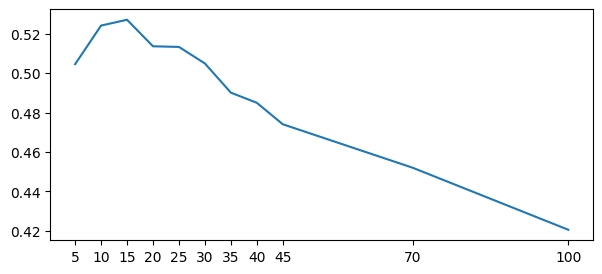

In [737]:
metrics_df.coherence_mean.plot(kind='line', xticks=metrics_df.index, figsize=(7, 3))

<Axes: >

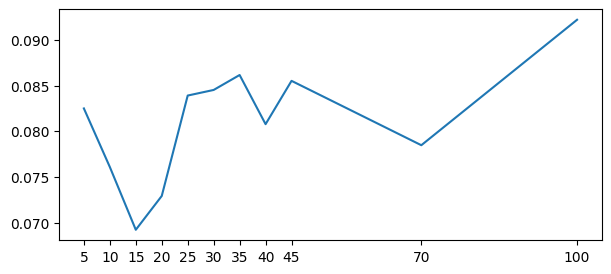

In [736]:
metrics_df.coherence_std.plot(kind='line', xticks=metrics_df.index, figsize=(7, 3))

<Axes: >

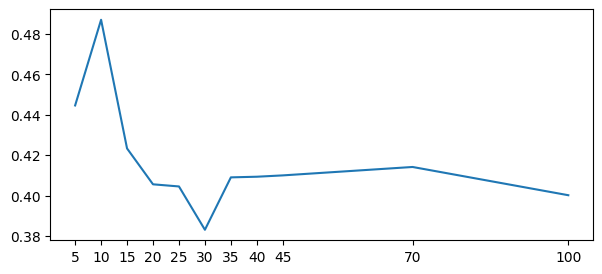

In [738]:
metrics_df.silhouette_mean.plot(kind='line', xticks=metrics_df.index, figsize=(7, 3))

<Axes: >

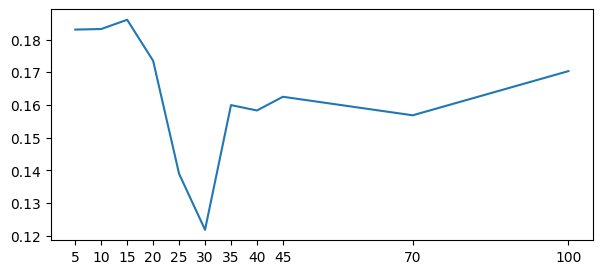

In [739]:
metrics_df.silhouette_std.plot(kind='line', xticks=metrics_df.index, figsize=(7, 3))

<Axes: >

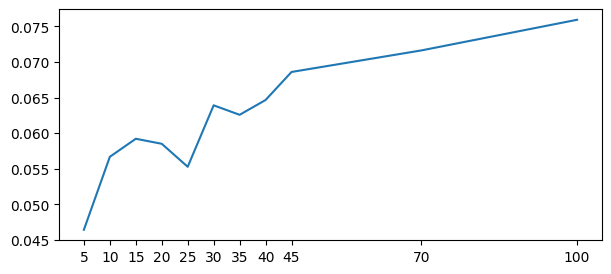

In [749]:
metrics_df.lanuage_imbalance_mean.plot(kind='line', xticks=metrics_df.index, figsize=(7, 3))

<Axes: >

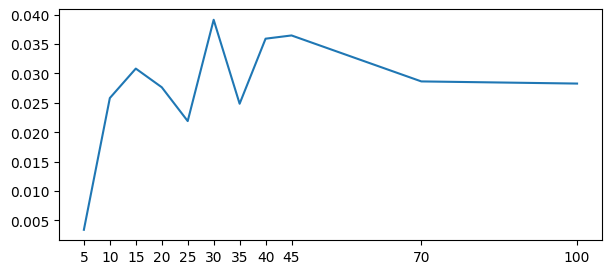

In [750]:
metrics_df.lanuage_imbalance_std.plot(kind='line', xticks=metrics_df.index, figsize=(7, 3))

<Axes: >

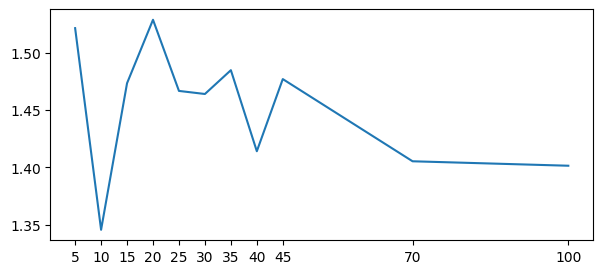

In [757]:
metrics_df.language_entropy_mean.plot(kind='line', xticks=metrics_df.index, figsize=(7, 3))

<Axes: >

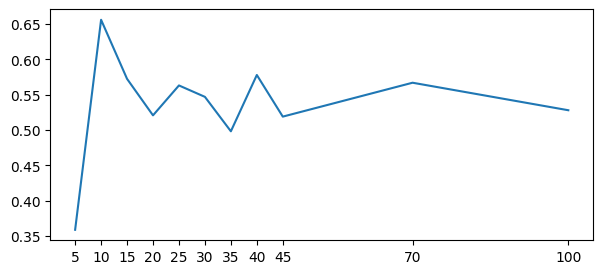

In [752]:
metrics_df.language_entropy_std.plot(kind='line', xticks=metrics_df.index, figsize=(7, 3))

<Axes: >

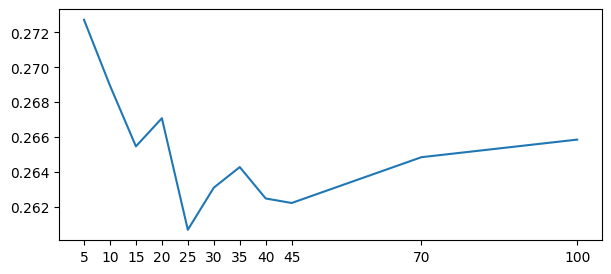

In [758]:
metrics_df.crosslingual_consistency_mean.plot(kind='line', xticks=metrics_df.index, figsize=(7, 3))

<Axes: >

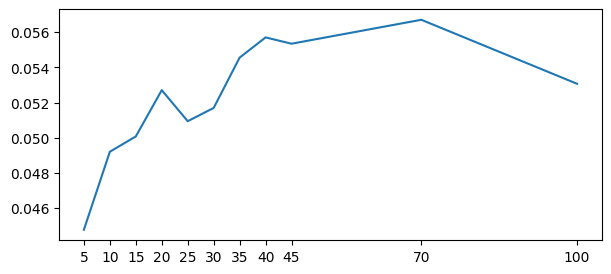

In [759]:
metrics_df.crosslingual_consistency_std.plot(kind='line', xticks=metrics_df.index, figsize=(7, 3))

Overall, it looks like 15 or 20 topics do a good job.
You could continue the process to explore models with 14, 16, 17, 18, 19, and 21 topics.

## Language-specific pre-processing and tokenization

There is no built-in support for langauge-specific pre-processing and tokenization in BERTopic.
So we need to implement it ourselves.

The way it works is through the `vectorizer_model` component.
Internally, this is used for tokenizing texts and producing document-term the matrix.

Below, I have code that expects that the first word in a document indicates its langauge (code).
This information is used to apply language-specific noramlizers, tokenizers, and stopword lists.

An alternative would be to pre-tokenize all texts, so that each document is represented with a list of tokens.
Then we could use the `CountVectorizer` to create the document-term matrix by passing it the argument `tokenizer=lambda x: x`. 
But you'd need to double-check if BERTopic internally relies somwhere on the raw texts instead of the tokenizer texts or the vectorized document-term matrix.
So this solution might require some [subclassing](https://chat.openai.com/share/64bf6f4b-0cb0-4edc-a119-7251309f95a6) of BERTopic.

In [411]:
import nltk
from nltk.tokenize import word_tokenize
# multilingual stopwords
from nltk.corpus import stopwords
from functools import partial
import re
from sacremoses import MosesPunctNormalizer
import string

class MultilingualWordTokenizer:
    
    SUPPORTED_LANGUAGES = [
        f.replace('.pickle', '') 
        for f in os.listdir(os.path.join(nltk.data.path[0], 'tokenizers', 'punkt'))
        if f.endswith('.pickle')
    ]

    def __init__(
            self, 
            languages: List[str], 
            remove_stopwords: bool = False, 
            remove_punctuation: bool = False, 
            lowercase: bool = False
    ):
        languages = [l.lower() for l in languages]
        unsupported = [l for l in languages if l not in self.SUPPORTED_LANGUAGES]
        if len(unsupported) > 0:
            raise ValueError(f'languages {unsupported} not supported by NLTK')
        self.languages = languages
        self.remove_stopwords = remove_stopwords
        self.remove_punctuation = remove_punctuation
        self.lowercase = lowercase
        self.tokenizers = {l: self._get_tokenizer(l) for l in languages}
        self.normalizer = {l: MosesPunctNormalizer(lang=iso639.to_iso639_1(l)) for l in languages}

    def _get_tokenizer(self, lang: str):
        return partial(word_tokenize, language=lang)
    
    def _tokenize(self, text: Union[str, List[str]]):
        if isinstance(text, list):
            return [self._tokenize(t) for t in text]
        
        lang, *rest = re.split(r'\s+', text.lstrip())
        # language-specific normalization
        text = self.normalizer[lang].normalize(' '.join(rest))
        # language-specific tokenization
        toks = self.tokenizers[lang](text)
        if self.remove_stopwords:
            # remove language-specific stopwords
            toks = [t for t in toks if t not in stopwords.words(lang)]
        if self.remove_punctuation:
            toks = [t for t in toks if t not in string.punctuation]
        if self.lowercase:
            toks = [t.lower() for t in toks]
        return toks

    def __iter__(self, text: List[str]):
        yield [self._tokenize(t) for t in text]
    
    def __call__(self, text: Union[str, List[str]]):
        return self._tokenize(text)


**_Note:_** You can add more steps to this pipeline, e.g., lemmatization, stemming, computing bi- and trigrams, etc. For eaxmpl

Here is how you use the `MultilingualWordTokenizer` class:
First, instantiate it with the languages it should support:

In [412]:
multilang_tokenizer = MultilingualWordTokenizer(
    languages=['german', 'english'], 
    remove_stopwords=True, 
    remove_punctuation=True, 
    lowercase=True
)

Then you can just pass it texts with the appropriate format `'<LANGUAGE> <TEXT>'`:

In [413]:
multilang_tokenizer('english Hello, world! This is a test.')

['hello', 'world', 'this', 'test']

Or a list of texts in the appropriate format:

In [414]:
multilang_tokenizer(['english Hello, world! This is a test.', 'german Hallo, Welt! Dies ist ein Test.'])

[['hello', 'world', 'this', 'test'], ['hallo', 'welt', 'dies', 'test']]

Le'ts put everyting together:

In [415]:
multilang_tokenizer = MultilingualWordTokenizer(
    languages=list(lang_code2name.values()), 
    remove_stopwords=True, 
    remove_punctuation=True, 
    lowercase=True
)

# bring the documents in the format expected by the tokenizer
docs = df.apply(lambda d: lang_code2name[d.lang] + ' ' + d.text, axis=1).tolist()

# instantiate a multilingual vectorizer with out custom tokenizer
multilingual_vectorizer_model = CountVectorizer(
    tokenizer=multilang_tokenizer,
    max_df=0.80,
    min_df=2,
    ngram_range=(1, 3),
    # options already handeled by custom tokenizer
    lowercase=False,
    stop_words=None
)

# create the topic model
multilingual_topic_model = BERTopic(

  # components
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=cluster_model,
  vectorizer_model=multilingual_vectorizer_model, # <== use our custom multilingual vectorizer here
  ctfidf_model=ctfidf_model,
  representation_model=KeyBERTInspired(top_n_words=30),
  
  top_n_words=30,

  verbose=True
)

# train
np.reandom.seed(SEED)
topics, probs = multilingual_topic_model.fit_transform(docs, embeddings=embeddings)

# note: takes a little longer because pushing texts through the multilingual tokenizer takes more time than the default white space splitting tokenization

2023-12-03 17:18:39,858 - BERTopic - Reduced dimensionality
2023-12-03 17:18:40,954 - BERTopic - Clustered reduced embeddings


Just a quick glance and the first topics top words representations shows that language-specific pre-processing and tokenization allows the model to find more interpretable topics (e.g., fewer stopwords).

In [416]:
[w for w, _ in multilingual_topic_model.topic_representations_[0]]

['uitgeprocedeerde asielzoekers',
 'asielzoekers',
 'asielprocedure',
 'asylum seekers',
 'asylsøkere',
 'og asylsøkere',
 'asylverfahren',
 'asylpolitik',
 'flüchtlingspolitik',
 'asylrecht',
 'asylmottak',
 'flüchtlingskonvention',
 'dutch asielzoekers',
 'opvang van vluchtelingen',
 'flygtninge',
 'recht auf asyl',
 'flyktninger',
 'des réfugiés',
 'auf asyl',
 'réfugiés',
 'van vluchtelingen',
 'vluchtelingen',
 'een verblijfsvergunning',
 'refugees',
 'refugee',
 'flüchtlingen',
 'flüchtlinge',
 "d'asile",
 'kvoteflyktninger',
 'die genfer flüchtlingskonvention']

In [417]:
[w for w, _ in multilingual_topic_model.topic_representations_[1]]

['norge norwegian',
 'norwegian norge',
 'norske samfunnet',
 'til norge',
 'norwegian sv',
 'norwegian det',
 'norge',
 'norsk',
 'norwegian at',
 'norske',
 'norwegian venstre',
 'at norge',
 'nordmenn',
 'norwegian sv vil',
 'sverige ska',
 'innvandrere',
 'samfund danish',
 'asylsøkere',
 'danish danmark',
 'swedish sverige',
 'flyktninger',
 'danmark',
 'danske',
 'arbeidsinnvandring',
 'sverige',
 'udlændinge',
 'svenska',
 'suomen',
 'danish det',
 'utenlandske']

In [418]:
[w for w, _ in multilingual_topic_model.topic_representations_[2]]

['unión europea spanish',
 'la unión europea',
 'der europäischen union',
 'europäischen integration',
 'unión europea',
 'europäischen union',
 'eu-staaten',
 'europea spanish',
 'asielbeleid',
 'inmigración',
 'política común',
 'europea',
 'una política común',
 'der europäischen',
 'europa',
 'europäisches',
 'in der europäischen',
 'estados miembros',
 'europees',
 'europäische',
 'europeo',
 'lidstaten',
 'europäischen',
 'europese',
 'europeos',
 'einer europäischen',
 'la unión',
 'in europa',
 'migratorios',
 'union german']

In [419]:
# for each language in df, flag the row that is first in the language group
scores, _ = compute_coherece(multilingual_topic_model, docs, coherence_metric='c_v')

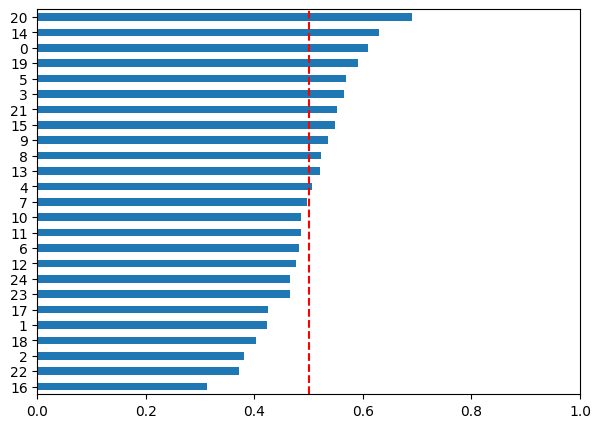

In [420]:
# visualize
def plot_topic_coherence_scores(scores, add_overall=True):
    coherences_df = pd.DataFrame(
        scores['by_topic'].values(), 
        index=range(len(scores['by_topic'])), 
        columns=['coherence']
    )
    # create new plot
    plt.figure(figsize=(7, 5))
    coherences_df.sort_values(by='coherence', inplace=True)
    coherences_df['coherence'].plot(kind='barh')
    if add_overall:
        # draw a vertical line at the overall coherence score
        plt.axvline(scores['overall'], color='red', linestyle='--')
    plt.xlim(0, 1)
    plt.show()

plot_topic_coherence_scores(scores)

**_Note:_** the advantage if this approach is that you could also add language-specific collocations (words that frequently co-occur) to the vocabulary.
You could identify them like this:

In [762]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
# see https://www.nltk.org/howto/collocations.html
language = 'english'
lang_code = 'eng'
bigram_measures = BigramAssocMeasures()
bigram_finder = BigramCollocationFinder.from_documents(df.loc[df.lang == lang_code, 'text'].apply(lambda x: word_tokenize(x, language=language)))
bigram_finder.window_size = 4
bigram_finder.apply_freq_filter(5)
ignored_words = nltk.corpus.stopwords.words(language)
bigram_finder.apply_word_filter(lambda w: len(w) < 2 or w.lower() in ignored_words)
bigram_collocations = bigram_finder.nbest(bigram_measures.pmi, 30)
bigram_collocations

[('United', 'States'),
 ('family', 'reunification'),
 ('Immigration', 'Service'),
 ('refugee', 'status'),
 ('illegal', 'aliens'),
 ('migrant', 'workers'),
 ('immigrant', 'communities'),
 ('asylum', 'seekers'),
 ('national', 'security'),
 ('illegal', 'entry'),
 ('Australia', "'s"),
 ('immigration', 'reform'),
 ('comprehensive', 'immigration'),
 ('immigration', 'programme'),
 ('immigration', 'system'),
 ('immigration', 'policy'),
 ('illegal', 'immigration')]

In [ ]:
topic_model.topics_[:10]

## Visualization

There are several visualization options available in BERTopic, namely the visualization of topics, probabilities and topics over time. Topic modeling is, to a certain extent, quite subjective. Visualizations help understand the topics that were created.

### Visualize Topics
After having trained our `BERTopic` model, we can iteratively go through perhaps a hundred topic to get a good
understanding of the topics that were extract. However, that takes quite some time and lacks a global representation.
Instead, we can visualize the topics that were generated in a way very similar to
[LDAvis](https://github.com/cpsievert/LDAvis):

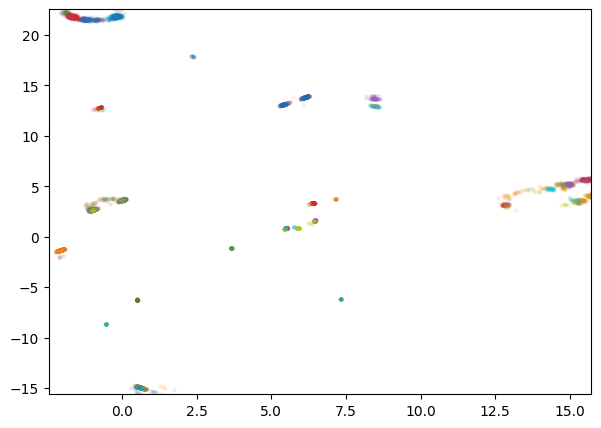

In [763]:
# plot the doc embeddings
plt.figure(figsize=(7, 5))
# set y-axis limits to range of topic embeddings
plt.xlim(topic_embeddings[:, 0].min(), topic_embeddings[:, 0].max())
plt.ylim(topic_embeddings[:, 1].min(), topic_embeddings[:, 1].max())

for tid in set(topic_model.topics_):
    idxs = np.array(topic_model.topics_)==tid
    plt.scatter(x=doc_embeddings[idxs, 0], y=doc_embeddings[idxs, 1], color=f'C{tid}', alpha=.1, s=5)


### Top terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [767]:
topic_model.visualize_barchart(top_n_topics=5)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.7918471097946167, 0.7985539436340332, 0.8091177344322205,
                    0.8653915524482727, 0.8791853785514832],
              'xaxis': 'x',
              'y': [flüchtlingskonvention  , flüchtlingspolitik  , asylverfahren
                    , asylsøkere  , asielzoekers  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.5612518787384033, 0.5612584948539734, 0.5874348282814026,
                    0.5879138112068176, 0.6002416610717773],
              'xaxis': 'x2',
              'y': [norskopplæring  , dansk  , danskere  , norge  , danmark  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.5496046543121338, 0.5538876056671143, 0.5564152002334595,
                    0.5673972964286804, 0.5848835706710815],
              'xaxis': 'x3',
              'y': [inmigración  , europa  , mitgliedstaaten  , europea  ,
                    asielbeleid  ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.5796678066253662, 0.6091189384460449, 0.6426918506622314,
                    0.6475052833557129, 0.6517159938812256],
              'xaxis': 'x4',
              'y': [illegale  , zuwanderung  , illegalen  , inmigración  ,
                    immigration  ],
              'yaxis': 'y4'},
             {'marker': {'color': '#56B4E9'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.6291779279708862, 0.6341830492019653, 0.6386478543281555,
                    0.6441141366958618, 0.6581597924232483],
              'xaxis': 'x5',
              'y': [educativo  , profesorado  , skolan  , onderwijs  , schulen  ],
              'yaxis': 'y5'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 0',
                                'x': 0.0875,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 1',
                                'x': 0.36250000000000004,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 2',
                                'x': 0.6375000000000001,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 3',
                                'x': 0.9125,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
 

### Topic similarity
Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [770]:
topic_model.visualize_heatmap(n_clusters=10, width=800, height=800)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>Similarity Score: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'x': [0_asielzoekers_asylsøkere_a..., 1_danmark_norge_danskere,
                    15_deutschlands_deutschland..., 16_einwanderungsland_österr...,
                    2_asielbeleid_europea_mitgl..., 20_nederland_nederlanders_n...,
                    3_immigration_inmigración_i..., 5_immigration_einwanderung_...,
                    8_indvandrere_inmigrante_in..., 11_migrantinnen_migranten_e...,
                    18_migratie_inmigración_mig..., 21_inmigración_inmigrantes_...,
                    4_schulen_onderwijs_skolan, 6_menschenrechte_igualdad_r...,
                    9_integración_integratie_in..., 10_interkulturelle_flerkult...,
                    17_unsere_uns_wir, 7_asylverfahren_asylbewerbe...,
                    12_género_inmigrantes_mujeres, 19_verblijfsvergunning_kind...,
                    23_maahanmuuttajien_inmigra..., 24_minoritetskvinner_kvinne...,
                    13_forskjellsbehandling_dis..., 14_arbeidsmigranten_migrant...,
                    22_islamfeindlichkeit_antis...],
              'xaxis': 'x',
              'y': [0_asielzoekers_asylsøkere_a..., 1_danmark_norge_danskere,
                    15_deutschlands_deutschland..., 16_einwanderungsland_österr...,
                    2_asielbeleid_europea_mitgl..., 20_nederland_nederlanders_n...,
                    3_immigration_inmigración_i..., 5_immigration_einwanderung_...,
                    8_indvandrere_inmigrante_in..., 11_migrantinnen_migranten_e...,
                    18_migratie_inmigración_mig..., 21_inmigración_inmigrantes_...,
                    4_schulen_onderwijs_skolan, 6_menschenrechte_igualdad_r...,
                    9_integración_integratie_in..., 10_interkulturelle_flerkult...,
                    17_unsere_uns_wir, 7_asylverfahren_asylbewerbe...,
                    12_género_inmigrantes_mujeres, 19_verblijfsvergunning_kind...,
                    23_maahanmuuttajien_inmigra..., 24_minoritetskvinner_kvinne...,
                    13_forskjellsbehandling_dis..., 14_arbeidsmigranten_migrant...,
                    22_islamfeindlichkeit_antis...],
              'yaxis': 'y',
              'z': array([[1.0000001 , 0.68659616, 0.6313178 , ..., 0.5370366 , 0.68176484,
                           0.5748124 ],
                          [0.68659616, 1.        , 0.833555  , ..., 0.5479258 , 0.629797  ,
                           0.5598606 ],
                          [0.6313178 , 0.833555  , 0.99999994, ..., 0.5468997 , 0.6077472 ,
                           0.5525247 ],
                          ...,
                          [0.5370366 , 0.5479258 , 0.5468997 , ..., 1.0000004 , 0.5975261 ,
                           0.6125335 ],
                          [0.68176484, 0.629797  , 0.6077472 , ..., 0.5975261 , 0.9999999 ,
                           0.45117736],
                          [0.5748124 , 0.5598606 , 0.5525247 , ..., 0.6125335 , 0.45117736,
                           1.0000002 ]], dtype=float32)}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'Similarity Score'}},
                             'colorscale': [[0.0, 'rgb(247,252,240)'], [0.125,
                                            'rgb(224,243,219)'], [0.25,
                                            'rgb(204,235,197)'], [0.375,
                                            'rgb(168,221,181)'], [0.5,
                                            'rgb(123,204,196)'], [0.625,
                                            'rgb(78,179,211)'], [0.75,
                                            'rgb(43,140,190)'], [0.875,
                                            'rgb(8,104,172)'], [1.0,
                                            'rgb(8,64,129)']]},
               'height': 800,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 

## Topic Reduction
We can also reduce the number of topics after having trained a BERTopic model. The advantage of doing so,
is that you can decide the number of topics after knowing how many are actually created. It is difficult to
predict before training your model how many topics that are in your documents and how many will be extracted.
Instead, we can decide afterwards how many topics seems realistic:





In [ ]:
if False:
    topic_model.reduce_topics(df.text, nr_topics=10)
    # Access the newly updated topics with:
    print(topic_model.topics_)

## Search topics

After having trained our model, we can use `find_topics` to search for topics that are similar
to an input search_term. Here, we are going to be searching for topics that closely relate the
search term "vehicle". Then, we extract the most similar topic and check the results:

In [803]:
similar_topics, similarity = topic_model.find_topics("need", top_n=5)
for tid, sim in zip(similar_topics, similarity):
    print(f'{s:.03f}\t{tid}\t{[t for t, _ in topic_model.get_topic(tid, full=True)["Translation"]]}')

0.391	17	['Our (de)', 'We (de)', 'We (de)', 'must (de)', 'Wants to (nl)', 'That is why (de)', 'must (nl)', 'will (no)', 'will (no)', 'we', 'to be (de)', 'but (de)', 'freelance (nl)', 'must (no)', 'Also (nl)', 'Also (de)', 'are (nl)', 'be (no)', 'Introduction (sv)', 'and (de)', 'can (no)', 'Proved (de)', 'with (de)', 'for (de)', 'can (fr)', 'that (de)', 'by (de)', 'Responsibility (de)', 'Society (de)', 'on (no)']
0.391	24	['Minority women (no)', 'Women (no)', 'migrants (de)', 'women (nl)', 'women (es)', 'Minority background (no)', 'The labour market (de)', 'migrants (nl)', 'Immigrants (es)', 'needs (es)', 'Working (no)', 'Work (no)', 'Recruitment (no)', 'sanitary (es)', 'The migration background (de)', 'The people (de)', 'Promotion (de)', 'Social (es)', 'Persons (no)', 'situation (es)', 'Problems (no)', 'Public (no)', 'Problems (es)', 'You are (de)', 'Services (es)', 'Disability (de)', 'youthful (de)', 'We (de)', 'to be (de)', 'Disabilities (de)']
0.391	12	['Gender (es)', 'Immigrants (e

In [804]:
similar_topics, similarity = topic_model.find_topics("crime", top_n=5)
for tid, sim in zip(similar_topics, similarity):
    print(f'{s:.03f}\t{tid}\t{[t for t, _ in topic_model.get_topic(tid, full=True)["Translation"]]}')

0.391	3	['immigration', 'Immigration (es)', 'Illegal (nl)', 'Immigration (de)', 'Illegal (de)', 'border', 'illegal', 'illegal (es)', 'The borders (es)', 'borders', 'Foreigners (de)', 'Foreigners (de)', 'Foreigners (de)', 'Foreign (no)', 'Expulsion (sv)', 'Criminality (de)', 'law', 'Crime (no)', 'Criminal (nl)', 'Criminality (nl)', 'Criminal (de)', 'against (nl)', 'against (de)', 'Human trafficking (no)', 'human trafficking (de)', 'human trafficking (nl)', 'We (de)', 'our', 'are', 'for (es)']
0.391	12	['Gender (es)', 'Immigrants (es)', 'women (es)', 'The Law State (nl)', 'Violence (no)', 'Violence (de)', 'Violence (es)', 'Protection (es)', 'victims (es)', 'situation (es)', 'against (de)', 'The case (es)', 'Rules (de)', 'dismissal (de)', 'The Girls (de)', 'The laws (nl)', 'procedures (de)', 'abolished (de)', 'We (de)', 'We not (fi)', 'We (de)', 'genital disturbance (de)', 'abolished (de)', 'You are (de)', 'How (de)', 'as (de)', 'to be (de)', 'Wants to (nl)', 'to be (nl)', 'must (nl)']
0.

## Saving a fitted model (model "serialization")

The model, its internal settings, and components (the embeddi) can easily be saved. 
Note that the documents and embeddings will *not* be saved.
However, UMAP and HDBSCAN will be saved.

In [ ]:
# Save model
topic_model.save("my_model")

In [ ]:
# Load model
my_model = BERTopic.load("my_model")

# **Embedding Models**
The parameter `embedding_model` takes in a string pointing to a sentence-transformers model, a SentenceTransformer, or a Flair DocumentEmbedding model.

## Sentence-Transformers
You can select any model from sentence-transformers here and pass it through BERTopic with embedding_model:



In [ ]:
topic_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")

Or select a SentenceTransformer model with your own parameters:


In [ ]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens", device="cpu")
topic_model = BERTopic(embedding_model=sentence_model, verbose=True)